In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)

from scipy import stats

In [2]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
data_df = pd.read_csv(path+'/clustered_df.csv', sep=',', header=0)
#data_df.reset_index(inplace=True)

In [3]:
data_df['date'] = pd.DatetimeIndex(data_df['date'])

In [4]:
data_df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'unique_id', 'Unnamed: 0', 'date',
       'time', 'date_time', 'agency', 'agency_name', 'inquiry_name',
       'brief_description', 'call_resolution', 'inquiry_with_description',
       'Inquiry_names', 'cluster_label', 'embed_0', 'embed_1',
       'Centroid_text'],
      dtype='object')

### Top 6 clusters according to count
5	Waterway Complaint	3357428
7	Living Wage Increase for Subsidized Projects	2359171
4	Reclaim a Towed Vehicle - NYPD	2320110
11	Smokeless Tobacco Law Information	1670471
3	Carpool or RideMatch	1645582
12	Find a Towed Vehicle - Blocking a Driveway	1243519
13	Pay a Parking Ticket - By Mail	1145085
0	Gas Service and Billing	1085403

In [5]:
all_clusters_data = data_df[data_df['cluster_label'].isin([5,7,4,11,3,12])]

In [6]:
_5_cluster_data = data_df[data_df['cluster_label']==5]
_7_cluster_data = data_df[data_df['cluster_label']==7]
_4_cluster_data = data_df[data_df['cluster_label']==4]
_11_cluster_data = data_df[data_df['cluster_label']==11]
_3_cluster_data = data_df[data_df['cluster_label']==3]
_12_cluster_data = data_df[data_df['cluster_label']==12]

In [7]:
daily_clusters_df = all_clusters_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")

In [8]:
daily_5_cluster_df = _5_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")
daily_7_cluster_df = _7_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")
daily_4_cluster_df = _4_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")
daily_11_cluster_df = _11_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")
daily_3_cluster_df = _3_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")
daily_12_cluster_df = _12_cluster_data.groupby(["date"]).size().reset_index(name="inquiries_per_day")

In [9]:
daily_clusters_df

,date,inquiries_per_day
0,2017-01-01,5153
1,2017-01-02,7882
2,2017-01-03,15439
3,2017-01-04,14965
4,2017-01-05,15029
...,...,...
1083,2019-12-27,9434
1084,2019-12-28,5335
1085,2019-12-29,4725
1086,2019-12-30,10827


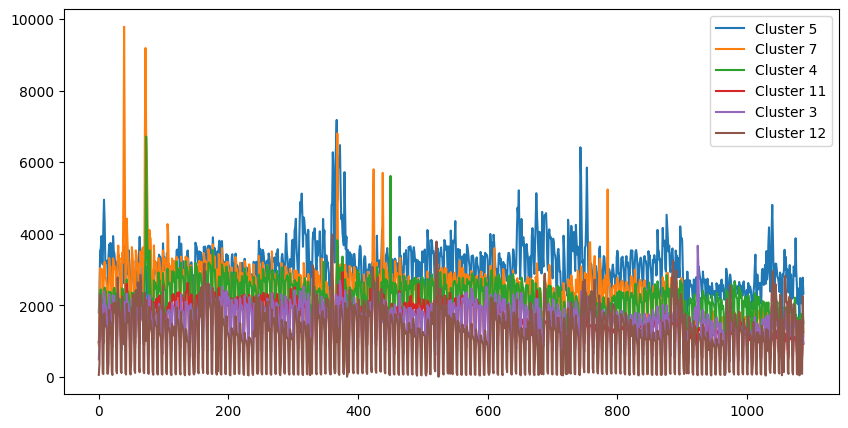

In [10]:
#plt.plot(daily_clusters_df['inquiries_per_day'], label='Data combined')
plt.plot(daily_5_cluster_df['inquiries_per_day'], label='Cluster 5')
plt.plot(daily_7_cluster_df['inquiries_per_day'], label='Cluster 7')
plt.plot(daily_4_cluster_df['inquiries_per_day'], label='Cluster 4')
plt.plot(daily_11_cluster_df['inquiries_per_day'], label='Cluster 11')
plt.plot(daily_3_cluster_df['inquiries_per_day'], label='Cluster 3')
plt.plot(daily_12_cluster_df['inquiries_per_day'], label='Cluster 12')
plt.legend();

## Feature Engineering

In [11]:
import holidays
nyc_holidays = holidays.US(state='NY', years=[2017,2018,2019])

In [12]:
# function to create seasons for dataframe
def get_seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''
    
    # create a season features
    df.loc[(df.index.month >=3) & (df.index.month <=5), 'season_spring'] = 1
    df.loc[(df.index.month >=6) & (df.index.month <=8), 'season_summer'] = 1
    df.loc[(df.index.month >=9) & (df.index.month <=11), 'season_fall'] = 1
    df.loc[((df.index.month >=1) & (df.index.month <=2)) | (df.index.month ==12), 'season_winter'] = 1

    return df

# function to create holidays for dataframe
def get_holidays(df):
    '''
    Function to create new features for holidays
    Args: df = dataframe
    Returns: df = dataframe
    '''

    # Create a DataFrame of holidays
    holidays_df = pd.DataFrame(nyc_holidays.items(), columns = ['date','holiday'])
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    holidays_df = holidays_df.set_index(['date'])
    
    # Join the holidays DataFrame with the original DataFrame
    df = df.join(holidays_df, on='date')
    df = df.replace(to_replace=r'[^0]', value=1, regex=True).fillna(0)

    return df

# function to create weekdays for dataframe
def get_weekdays(df):
    '''
    Function to create new features for holidays
    Args: df = dataframe
    Returns: df = dataframe
    '''
    df['weekday'] = df.index.weekday
    ### one hot encode the feature weekday
    weekday_dummies = pd.get_dummies(df['weekday'], prefix='weekday')
    df = df.join(weekday_dummies, how='left')

    return df


Sunday - 6
Monday - 0
Tuesday - 1
Wednesday - 2
Thursday - 3
Friday - 4
Saturday - 5

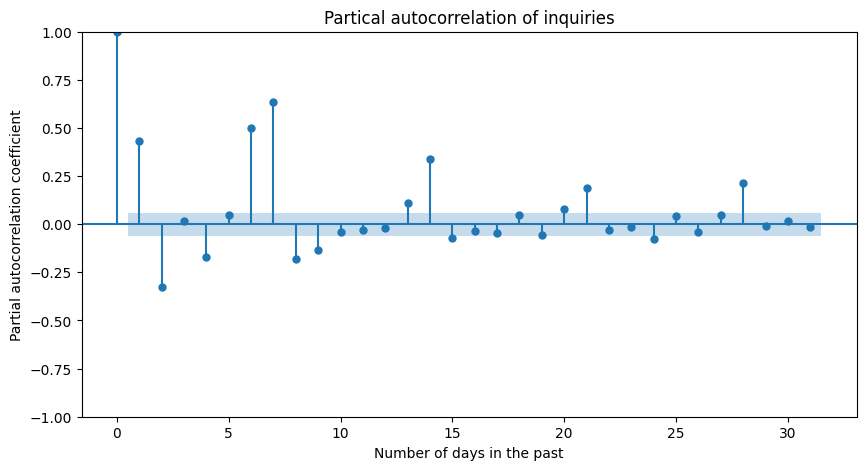

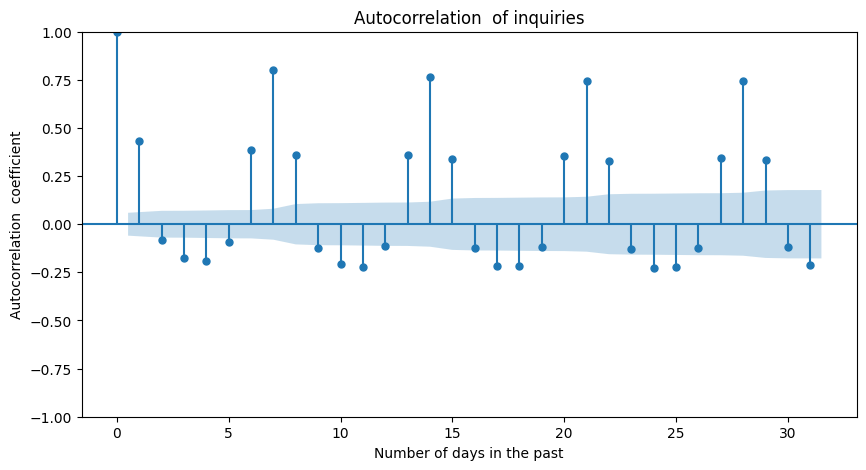

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plotting the partial autocorrelation for target
plot_pacf(daily_clusters_df['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_clusters_df['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [14]:
# function to create weekdays for dataframe
def get_features(df,lags):
    '''
    Function to create new features
    Args: df = dataframe, lags = number of lags with high correlation
    Returns: df = dataframe
    '''
    df.reset_index(inplace = True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace = True)

    df = get_seasons(df).fillna(0)
    df = get_holidays(df)
    df = get_weekdays(df)
    df[f'Inq_mean_{lags}'] = df['inquiries_per_day'].rolling(window=lags).mean()

    return df



# Overall combined dataset of 6 top clusters

In [15]:
daily_clusters_df = get_features(daily_clusters_df,7)

In [16]:
from scipy.stats import chi2_contingency, randint

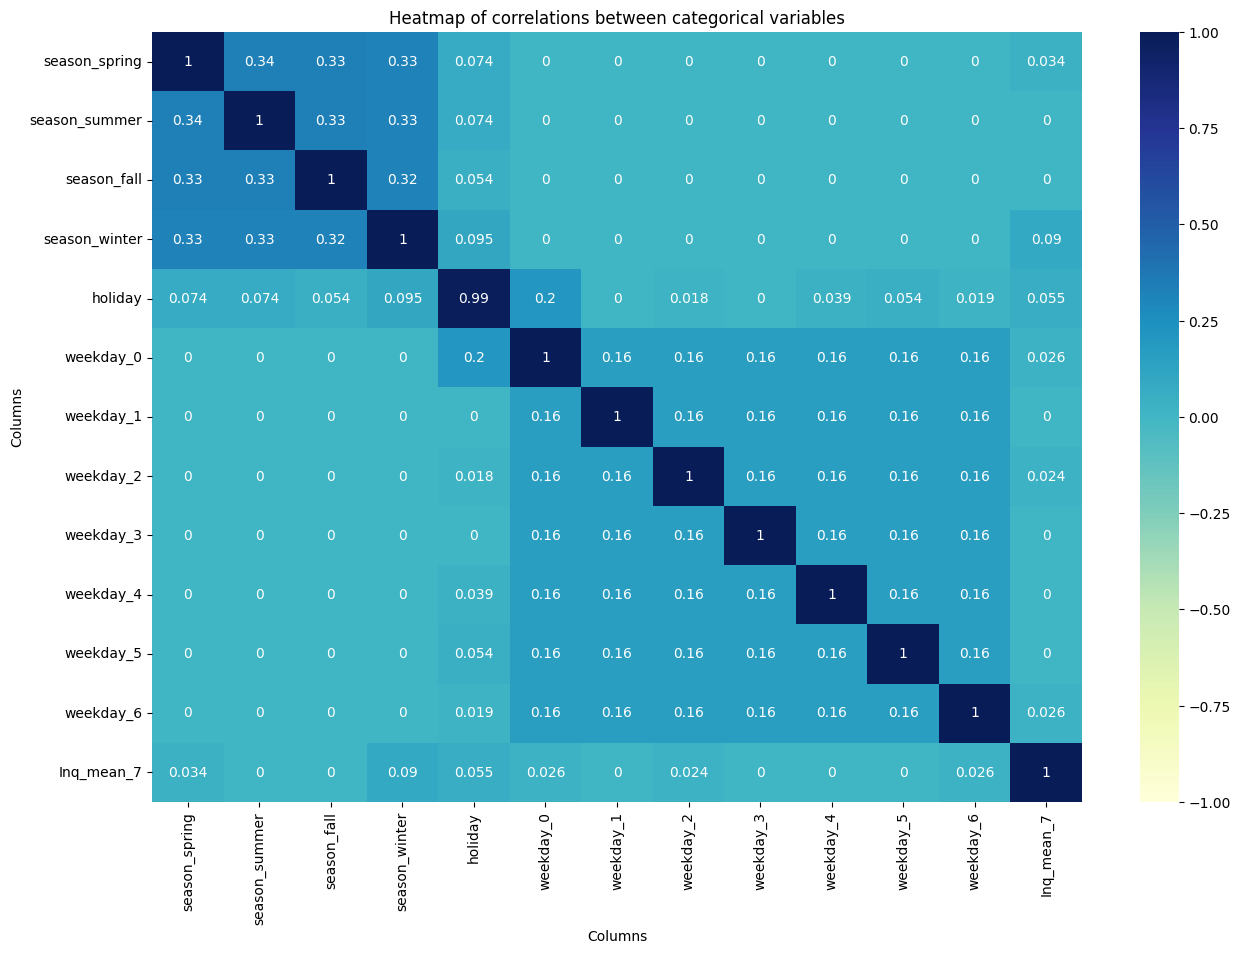

In [17]:
# drop any non-categorical variables
Daily_data_corr_cat = daily_clusters_df.drop(columns=['index','weekday', 'inquiries_per_day'], axis=1)


# this code snippet was taken from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# create correlation matrix with cramer's V coefficients
corr_matrix = pd.DataFrame(data = None, index=np.arange(len(Daily_data_corr_cat.columns)), 
                            columns=Daily_data_corr_cat.columns)

for col in Daily_data_corr_cat.columns:
    count = 0
    for val in Daily_data_corr_cat.columns:
        corr_cat = cramers_v(Daily_data_corr_cat[col], Daily_data_corr_cat[val])
        corr_matrix[col][count] = corr_cat
        count += 1
    corr_matrix = corr_matrix.astype('float')


# add an index to the dataframe
corr_matrix['columns'] = Daily_data_corr_cat.columns
corr_matrix.set_index('columns', inplace=True)

# plot a heatmap for correlations between categorical variables
plt.figure(figsize=[15,10])
sns.heatmap(corr_matrix, annot=True,
          vmin=-1, vmax=1, center=0,
          fmt='.2g', cmap='YlGnBu')
plt.title('Heatmap of correlations between categorical variables')
plt.xlabel('Columns')
plt.ylabel('Columns');

### Modeling with Lazy Predict

In [18]:
final_df  = daily_clusters_df.drop(columns=['weekday', 'index']).fillna(0)
final_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Inq_mean_7'],
      dtype='object')

In [19]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:24<00:00,  1.72it/s]

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
GradientBoostingRegressor                    0.90       0.90   1054.14   
RandomForestRegressor                        0.88       0.89   1153.71   
HistGradientBoostingRegressor                0.88       0.88   1156.80   
LGBMRegressor                                0.88       0.88   1162.71   
KNeighborsRegressor                          0.86       0.87   1227.16   
BaggingRegressor                             0.86       0.87   1242.00   
ExtraTreesRegressor                          0.85       0.86   1297.18   
PoissonRegressor                             0.84       0.85   1331.88   
XGBRegressor                                 0.84       0.85   1333.24   
RidgeCV                                      0.81       0.82   1428.50   
LinearRegression                             0.81       0.82   1429.18   
TransformedTargetRegressor            

### RandomForestRegressor

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [21]:
# Load dataset into a pandas dataframe
df = final_df
# assigning X and y
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# Split the dataset into training and test sets
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model on the training set using RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data, train_target)

# Make predictions on the test set
predictions = model.predict(test_data).astype(int)

# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse = mean_squared_error(test_target, predictions)

# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = predictions.var()
bias = mse - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Model: Random Forest Regressor
Variance: 11507753.023735376
Bias: -10176774.638414275


In [22]:
rmse = np.sqrt(mean_squared_error(test_target, predictions))
rmse

1153.6803653183583

### Hyperparameter Tuning with cross validation

In [23]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV

Grid search on combined dataset

In [24]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_df['inquiries_per_day']
X = final_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


Modeling with best parameters

In [25]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_all = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_all.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the test set
train_pred = best_rfr_all.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("Train MAE: ", train_mae)
print('Train RMSE:', train_rmse)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_allTopClusters = best_rfr_all.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae = mean_absolute_error(y_test, test_pred_allTopClusters)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_all = mean_squared_error(y_test, test_pred_allTopClusters)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_allTopClusters))
print("Test MAE: ", test_mae)
print('Test RMSE:', test_rmse)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = test_pred_allTopClusters.var()
bias = mse_all - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Train MAE:  418.90459770114944
Train RMSE: 675.4609911569377
Test MAE:  2275.0045871559632
Test RMSE: 2733.7822901781597
Model: Random Forest Regressor
Variance: 11067732.476811714
Bias: -3594166.8667199714


Data is still overfitting, but the low bias by default hyperparameters of RFRegressor is increased after hyperparameter tuning 

In [26]:
train_rf = pd.DataFrame()
train_rf['train'] = y_train
train_rf['train_pred'] = train_pred
predictions_rf = pd.DataFrame()
predictions_rf['test'] = y_test
predictions_rf['test_pred'] = test_pred_allTopClusters
train_rf['residuals'] = train_rf['train'] - train_rf['train_pred']
predictions_rf['residuals'] = predictions_rf['test'] - predictions_rf['test_pred']

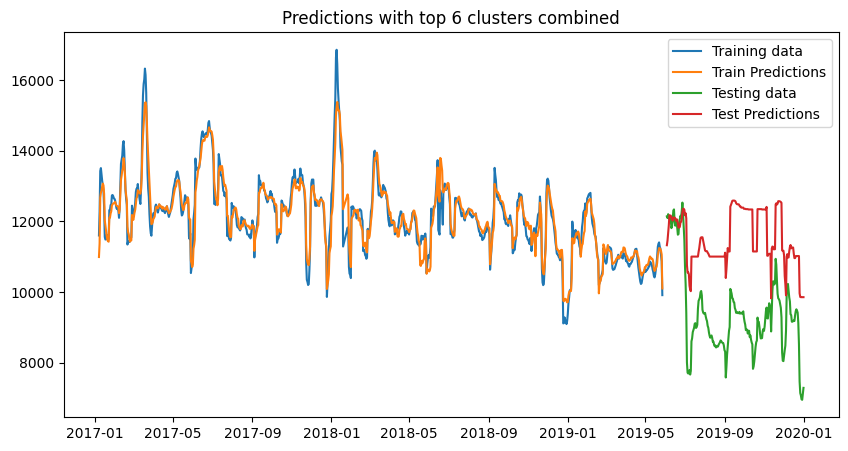

In [27]:
plt.title('Predictions with top 6 clusters combined')
plt.plot(train_rf[['train']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf[['train_pred']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(predictions_rf[['test','test_pred']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
#plt.plot(predictions_rf['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [28]:
new_plot=train_rf[train_rf.index.year == 2019]

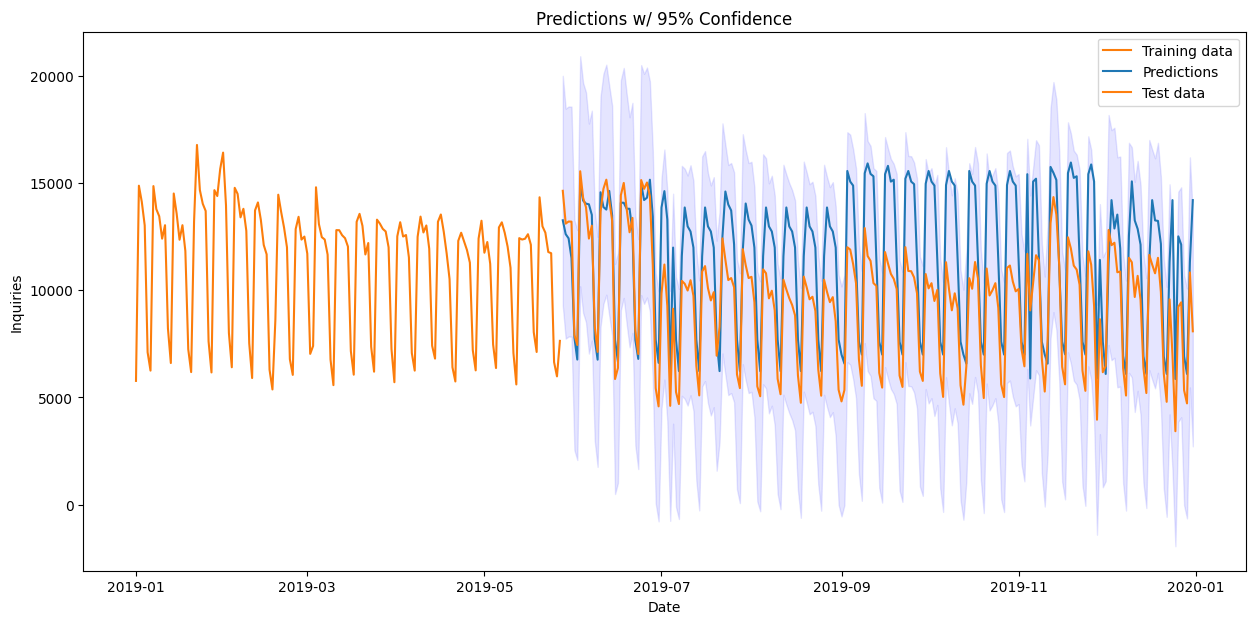

In [29]:
RMSFE = np.sqrt(sum([x**2 for x in predictions_rf['residuals'] ]) / len(predictions_rf['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['train'], color='#fc7d0b', label='Training data')
ax.plot(predictions_rf.index, predictions_rf['test_pred'], label='Predictions')
ax.plot(predictions_rf.index, predictions_rf['test'], label='Test data')
ax.fill_between(predictions_rf.index, (predictions_rf['test']-band_size), (predictions_rf['test']+band_size), color='b', alpha=.1)
ax.set_title("Predictions w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

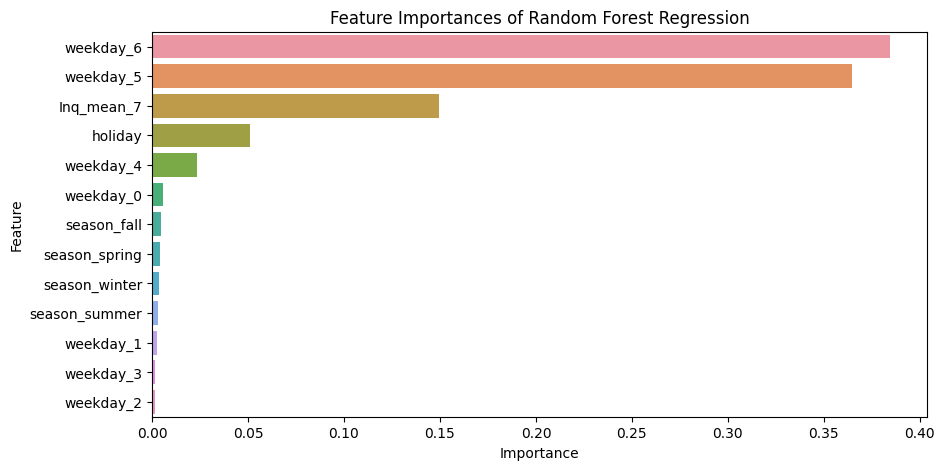

In [30]:
# Access the feature importances
importances = best_rfr_all.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [31]:
train_rf

,train,train_pred,residuals
date,,,
2017-01-01,5153,5487,-334
2017-01-02,7882,6770,1112
2017-01-03,15439,15095,344
2017-01-04,14965,14391,574
2017-01-05,15029,14159,870
...,...,...,...
2019-05-23,11778,12473,-695
2019-05-24,11720,11494,226
2019-05-25,6648,7031,-383


In [32]:
predictions_rf

,test,test_pred,residuals
date,,,
2019-05-28,14628,13256,1372
2019-05-29,13099,12610,489
2019-05-30,13198,12414,784
2019-05-31,13191,11492,1699
2019-06-01,7911,7795,116
...,...,...,...
2019-12-27,9434,12123,-2689
2019-12-28,5335,6918,-1583
2019-12-29,4725,6096,-1371


# 1st Top cluster --> cluster_label = 5

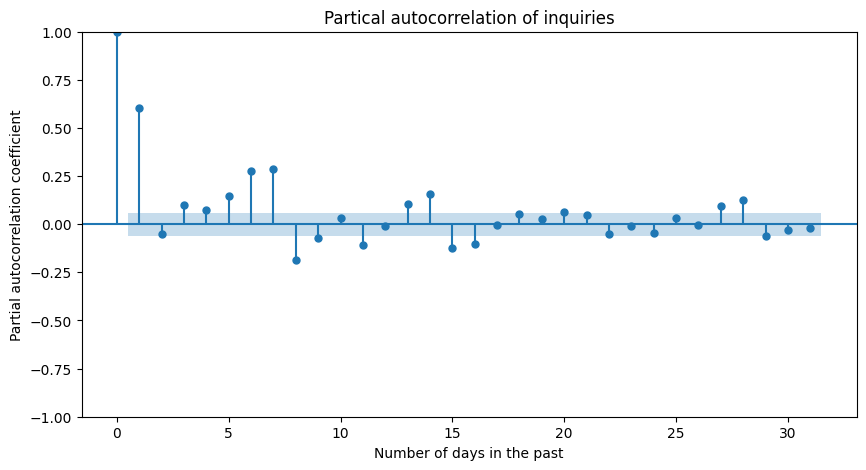

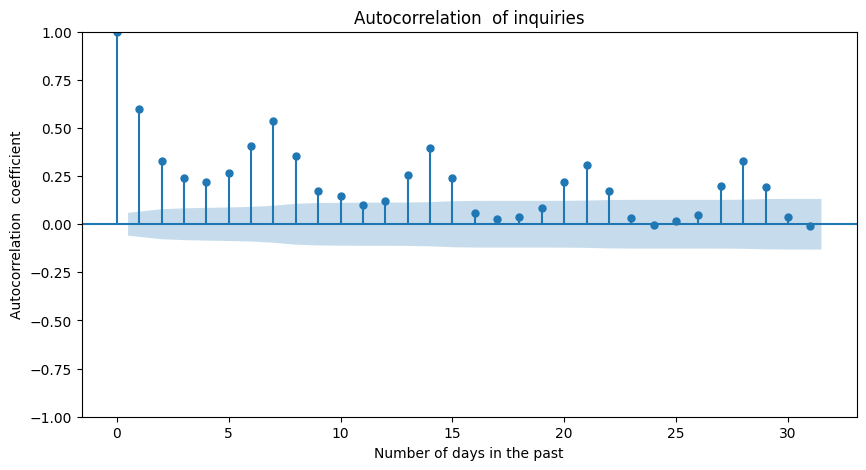

In [33]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plotting the partial autocorrelation for target
plot_pacf(daily_5_cluster_df['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_5_cluster_df['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [34]:
daily_5_cluster_df = get_features(daily_5_cluster_df,7)

In [35]:
from scipy.stats import chi2_contingency, randint

### Modeling with Lazy Predict

In [36]:
final_5_df  = daily_5_cluster_df.drop(columns=['weekday', 'index']).fillna(0)
final_5_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Inq_mean_7'],
      dtype='object')

In [37]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_5_df['inquiries_per_day']
X = final_5_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:22<00:00,  1.86it/s]

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
GradientBoostingRegressor                    0.54       0.57    447.96   
PoissonRegressor                             0.48       0.51    478.81   
LGBMRegressor                                0.47       0.50    482.52   
RandomForestRegressor                        0.46       0.50    484.65   
HistGradientBoostingRegressor                0.46       0.49    486.74   
KNeighborsRegressor                          0.45       0.48    491.81   
BaggingRegressor                             0.44       0.48    493.66   
ElasticNetCV                                 0.43       0.46    500.95   
ElasticNet                                   0.42       0.46    503.74   
RidgeCV                                      0.41       0.45    507.85   
BayesianRidge                                0.41       0.45    508.10   
Ridge                                 

### RandomForestRegressor

In [38]:
# Load dataset into a pandas dataframe
df = final_5_df
# assigning X and y
y = final_5_df['inquiries_per_day']
X = final_5_df.drop(columns=['inquiries_per_day'])

# Split the dataset into training and test sets
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model on the training set using RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data, train_target)

# Make predictions on the test set
predictions = model.predict(test_data).astype(int)

# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse = mean_squared_error(test_target, predictions)

# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = predictions.var()
bias = mse - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Model: Random Forest Regressor
Variance: 375201.77301994775
Bias: -140171.83265297528


In [39]:
rmse = np.sqrt(mean_squared_error(test_target, predictions))
rmse

484.79886588870284

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [40]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_5_df['inquiries_per_day']
X = final_5_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


Modeling with best parameters

In [41]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster5 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster5.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_5 = best_rfr_cluster5.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_5 = mean_absolute_error(y_train, train_pred_5)
train_rmse_5 = np.sqrt(mean_squared_error(y_train, train_pred_5))
print("Train MAE of Cluster #5: ", train_mae_5)
print('Train RMSE of Cluster #5:', train_rmse_5)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_5 = best_rfr_cluster5.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_5 = mean_absolute_error(y_test, test_pred_5)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_5 = mean_squared_error(y_test, test_pred_5)
test_rmse_5 = np.sqrt(mean_squared_error(y_test, test_pred_5))
print("Test MAE of Cluster #5: ", test_mae_5)
print('Test RMSE of Cluster #5:', test_rmse_5)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_5 = test_pred_5.var()
bias_5 = mse_5 - variance_5
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #5: {variance_5}')
print(f'Bias of Cluster #5: {bias_5}')

Train MAE of Cluster #5:  207.30574712643678
Train RMSE of Cluster #5: 311.1720705192938
Test MAE of Cluster #5:  325.9357798165138
Test RMSE of Cluster #5: 408.74627063921685
Model: Random Forest Regressor
Variance of Cluster #5: 212120.84767696323
Bias of Cluster #5: -45047.33391549534


Model: Random Forest Regressor
Variance: 375182.21355143504
Bias: -140199.54230831578

Data is not overfitting, but the low bias by default hyperparameters of RFRegressor is increased after hyperparameter tuning 

In [42]:
train_rf_5 = pd.DataFrame()
train_rf_5['actual_data'] = y_train
train_rf_5['predictions'] = train_pred_5
test_rf_5 = pd.DataFrame()
test_rf_5['actual_data'] = y_test
test_rf_5['predictions'] = test_pred_5
train_rf_5['residuals'] = train_rf_5['actual_data'] - train_rf_5['predictions']
test_rf_5['residuals'] = test_rf_5['actual_data'] - test_rf_5['predictions']

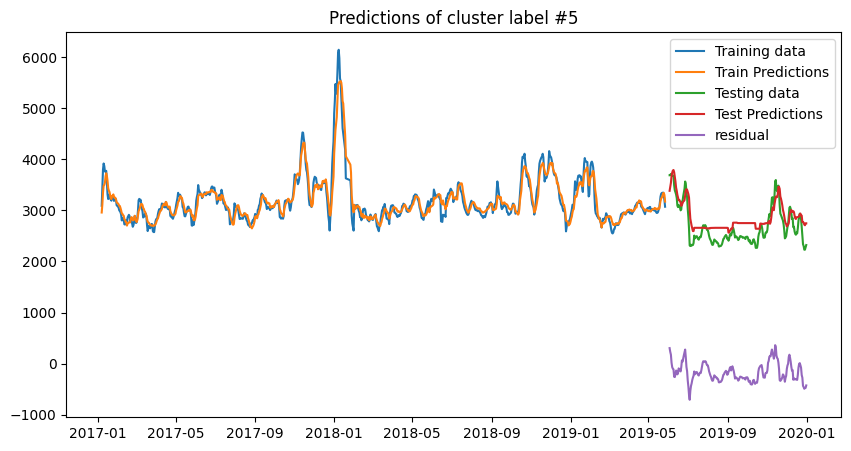

In [43]:
plt.title('Predictions of cluster label #5')
plt.plot(train_rf_5[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_5[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_5[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_5['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [44]:
new_plot=train_rf_5[train_rf_5.index.year == 2019]

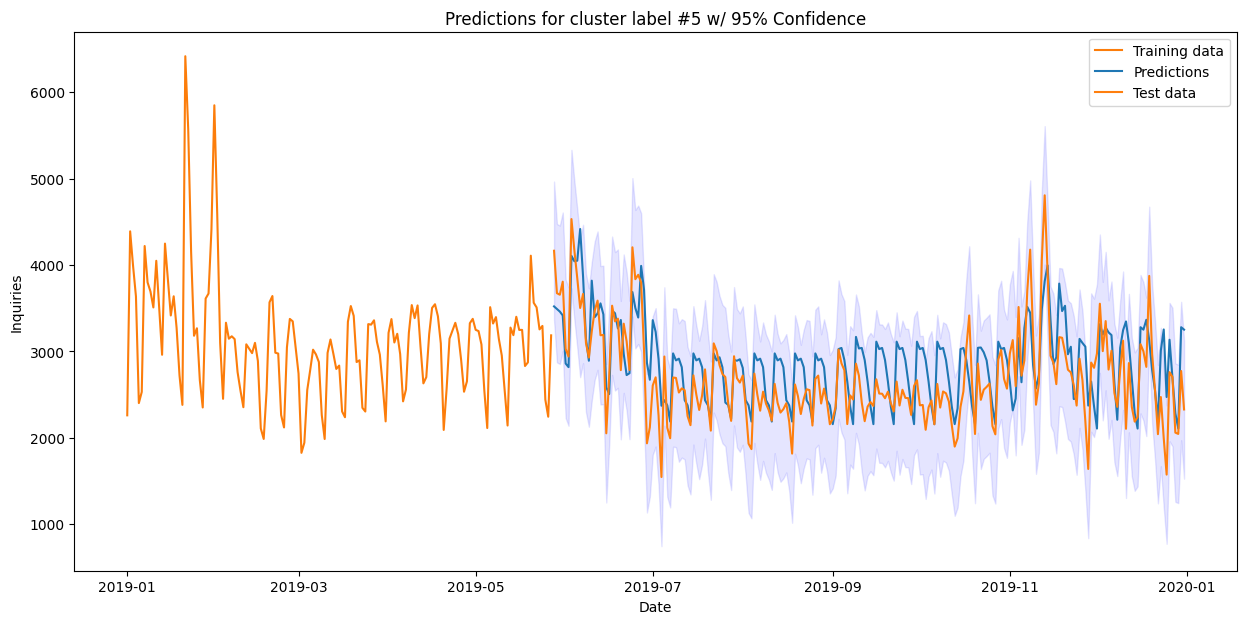

In [45]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_5['residuals'] ]) / len(test_rf_5['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_5.index, test_rf_5['predictions'], label='Predictions')
ax.plot(test_rf_5.index, test_rf_5['actual_data'], label='Test data')
ax.fill_between(test_rf_5.index, (test_rf_5['actual_data']-band_size), (test_rf_5['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #5 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

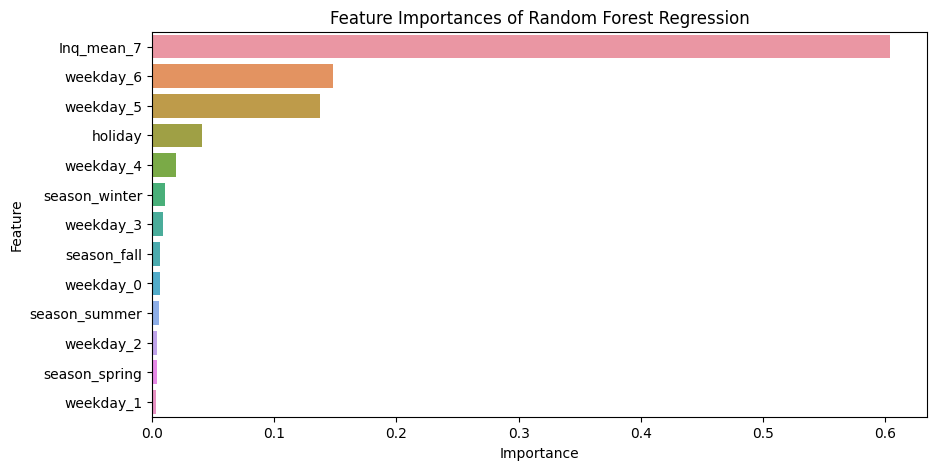

In [46]:
# Access the feature importances
importances = best_rfr_cluster5.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [47]:
test_rf_5

,actual_data,predictions,residuals
date,,,
2019-05-28,4165,3521,644
2019-05-29,3674,3491,183
2019-05-30,3656,3461,195
2019-05-31,3807,3416,391
2019-06-01,3030,2860,170
...,...,...,...
2019-12-27,2704,2693,11
2019-12-28,2060,2284,-224
2019-12-29,2045,2107,-62


In [48]:
train_rf_5

,actual_data,predictions,residuals
date,,,
2017-01-01,1799,2039,-240
2017-01-02,2405,2396,9
2017-01-03,3518,3553,-35
2017-01-04,3586,3579,7
2017-01-05,3934,3506,428
...,...,...,...
2019-05-23,3255,3472,-217
2019-05-24,3295,3393,-98
2019-05-25,2442,2654,-212


# 2nd Top cluster --> cluster_label = 7

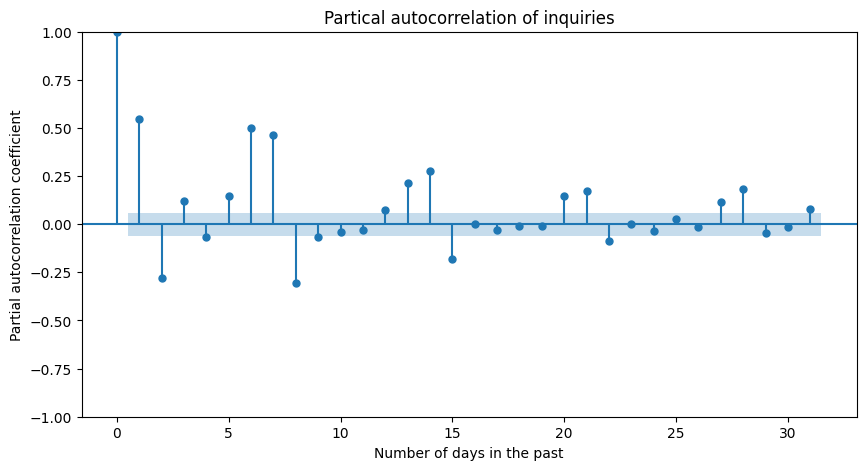

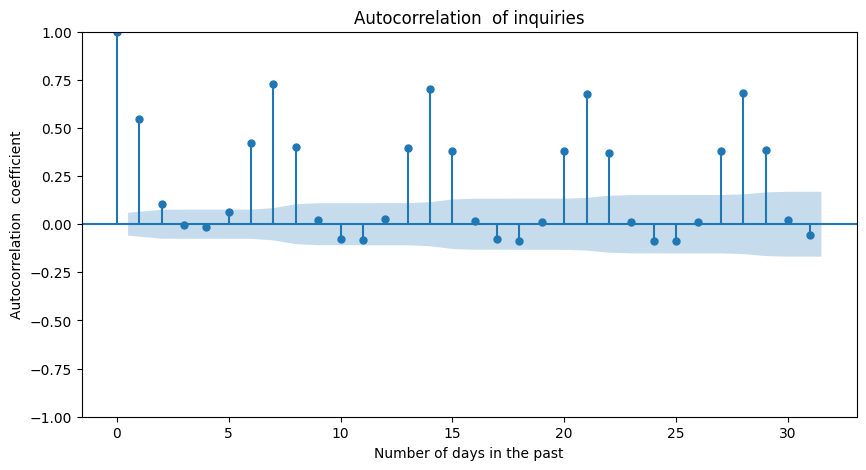

In [49]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plotting the partial autocorrelation for target
plot_pacf(daily_7_cluster_df['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_7_cluster_df['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [50]:
daily_7_cluster_df = get_features(daily_7_cluster_df,7)

### Modeling with Lazy Predict

In [51]:
final_7_df  = daily_7_cluster_df.drop(columns=['weekday', 'index']).fillna(0)
final_7_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Inq_mean_7'],
      dtype='object')

In [52]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_7_df['inquiries_per_day']
X = final_7_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:27<00:00,  1.55it/s]

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
HistGradientBoostingRegressor                0.72       0.74    540.01   
LGBMRegressor                                0.72       0.74    540.64   
RandomForestRegressor                        0.71       0.72    553.86   
SGDRegressor                                 0.70       0.72    562.01   
TransformedTargetRegressor                   0.70       0.72    562.02   
LinearRegression                             0.70       0.72    562.02   
RidgeCV                                      0.70       0.72    562.29   
BayesianRidge                                0.70       0.72    562.32   
Ridge                                        0.70       0.72    562.35   
Lars                                         0.70       0.72    562.36   
LassoLarsIC                                  0.70       0.72    562.36   
Lasso                                 

### RandomForestRegressor

In [53]:
# Load dataset into a pandas dataframe
df = final_7_df
# assigning X and y
y = final_7_df['inquiries_per_day']
X = final_7_df.drop(columns=['inquiries_per_day'])

# Split the dataset into training and test sets
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model on the training set using RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data, train_target)

# Make predictions on the test set
predictions = model.predict(test_data).astype(int)

# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse = mean_squared_error(test_target, predictions)

# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = predictions.var()
bias = mse - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Model: Random Forest Regressor
Variance: 899488.5723634373
Bias: -592715.7604368317


In [54]:
rmse = np.sqrt(mean_squared_error(test_target, predictions))
rmse

553.8707538104946

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [55]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_7_df['inquiries_per_day']
X = final_7_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


Modeling with best parameters

In [56]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster7 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster7.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_7 = best_rfr_cluster7.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_7 = mean_absolute_error(y_train, train_pred_7)
train_rmse_7 = np.sqrt(mean_squared_error(y_train, train_pred_7))
print("Train MAE of Cluster #7: ", train_mae_7)
print('Train RMSE of Cluster #7:', train_rmse_7)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_7 = best_rfr_cluster7.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_7 = mean_absolute_error(y_test, test_pred_7)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_7 = mean_squared_error(y_test, test_pred_7)
test_rmse_7 = np.sqrt(mean_squared_error(y_test, test_pred_7))
print("Test MAE of Cluster #7: ", test_mae_7)
print('Test RMSE of Cluster #7:', test_rmse_7)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_7 = test_pred_7.var()
bias_7 = mse_7 - variance_7
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #7: {variance_7}')
print(f'Bias of Cluster #7: {bias_7}')

Train MAE of Cluster #7:  161.56436781609196
Train RMSE of Cluster #7: 345.2827943092111
Test MAE of Cluster #7:  567.059633027523
Test RMSE of Cluster #7: 666.184648756283
Model: Random Forest Regressor
Variance of Cluster #7: 497736.8532320512
Bias of Cluster #7: -53934.86699351907


Train MAE of Cluster #5:  205.11904761904762
Train RMSE of Cluster #5: 305.066875785128
Test MAE of Cluster #5:  283.8170731707317
Test RMSE of Cluster #5: 368.21515780725866
Model: Random Forest Regressor
Variance of Cluster #5: 155689.43080755504
Bias of Cluster #5: -20107.02836853065

Model: Random Forest Regressor
Variance: 375182.21355143504
Bias: -140199.54230831578

Data is not overfitting, but the low bias by default hyperparameters of RFRegressor is increased after hyperparameter tuning 

In [57]:
train_rf_7 = pd.DataFrame()
train_rf_7['actual_data'] = y_train
train_rf_7['predictions'] = train_pred_7
test_rf_7 = pd.DataFrame()
test_rf_7['actual_data'] = y_test
test_rf_7['predictions'] = test_pred_7
train_rf_7['residuals'] = train_rf_7['actual_data'] - train_rf_7['predictions']
test_rf_7['residuals'] = test_rf_7['actual_data'] - test_rf_7['predictions']

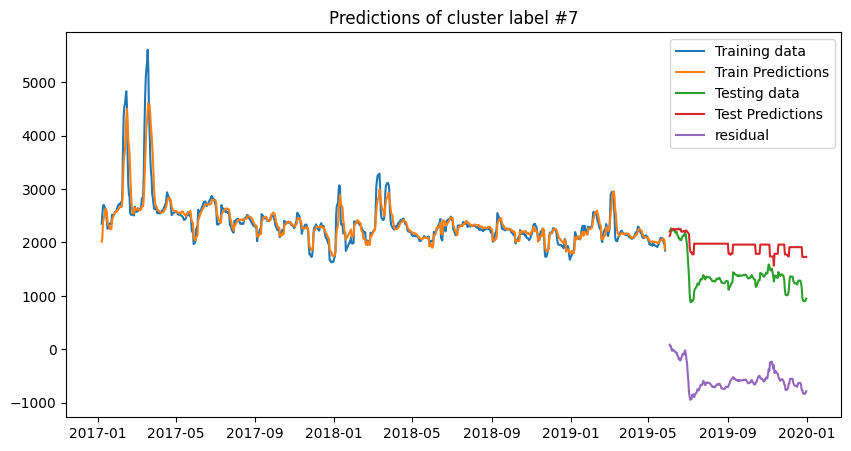

In [58]:
plt.title('Predictions of cluster label #7')
plt.plot(train_rf_7[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_7[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_7[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_7['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [59]:
new_plot=train_rf_7[train_rf_7.index.year == 2019]

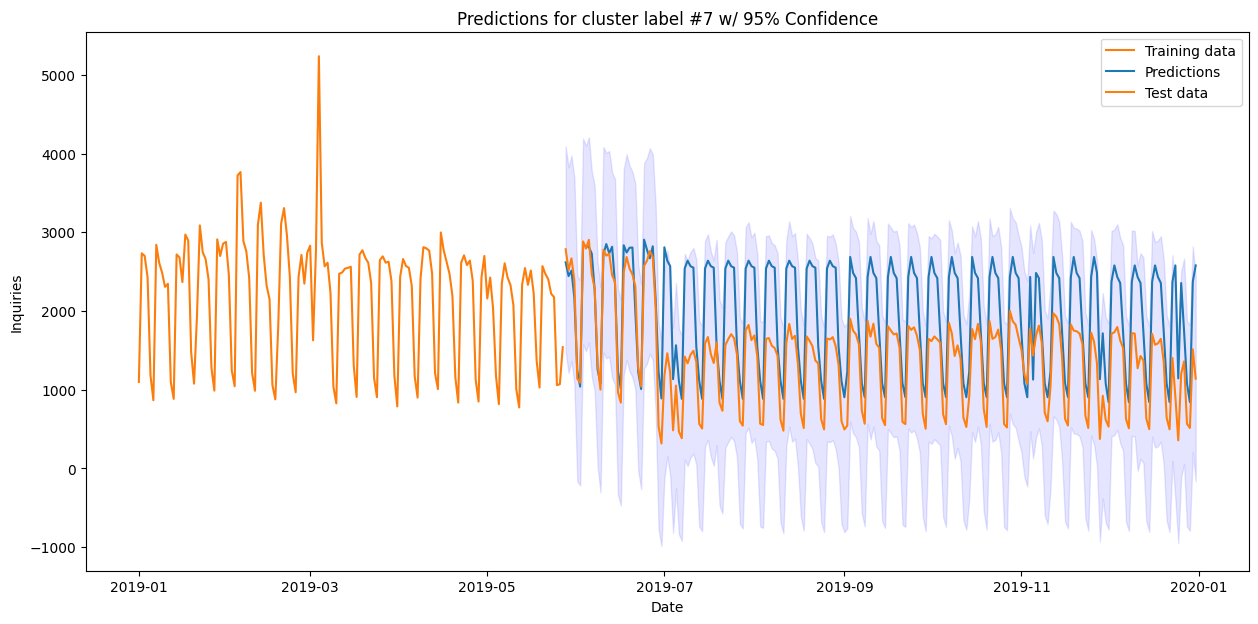

In [60]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_7['residuals'] ]) / len(test_rf_7['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_7.index, test_rf_7['predictions'], label='Predictions')
ax.plot(test_rf_7.index, test_rf_7['actual_data'], label='Test data')
ax.fill_between(test_rf_7.index, (test_rf_7['actual_data']-band_size), (test_rf_7['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #7 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

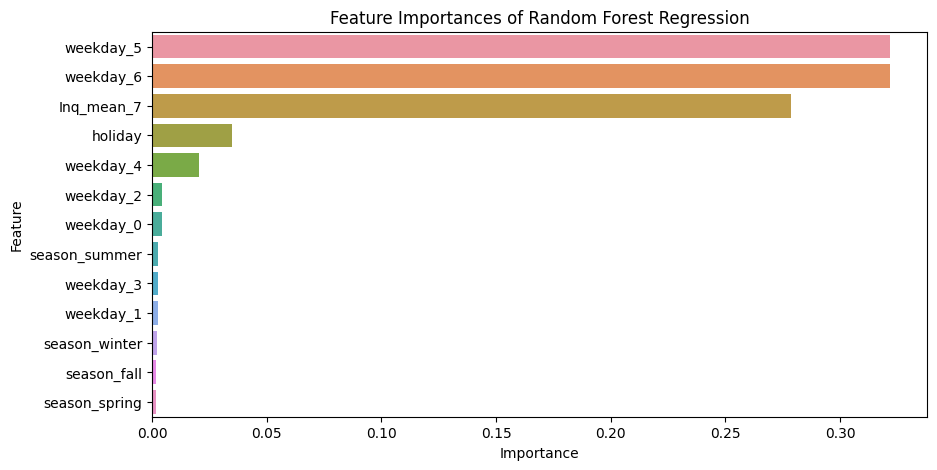

In [61]:
# Access the feature importances
importances = best_rfr_cluster7.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [62]:
test_rf_7

,actual_data,predictions,residuals
date,,,
2019-05-28,2785,2619,166
2019-05-29,2520,2444,76
2019-05-30,2669,2514,155
2019-05-31,2386,2164,222
2019-06-01,1141,1247,-106
...,...,...,...
2019-12-27,1360,1745,-385
2019-12-28,566,1077,-511
2019-12-29,514,843,-329


In [63]:
train_rf_7

,actual_data,predictions,residuals
date,,,
2017-01-01,875,843,32
2017-01-02,2002,1354,648
2017-01-03,3039,2792,247
2017-01-04,2911,2777,134
2017-01-05,3021,2743,278
...,...,...,...
2019-05-23,2220,2370,-150
2019-05-24,2177,2280,-103
2019-05-25,1058,1087,-29


# 3rd Top cluster --> cluster_label = 4

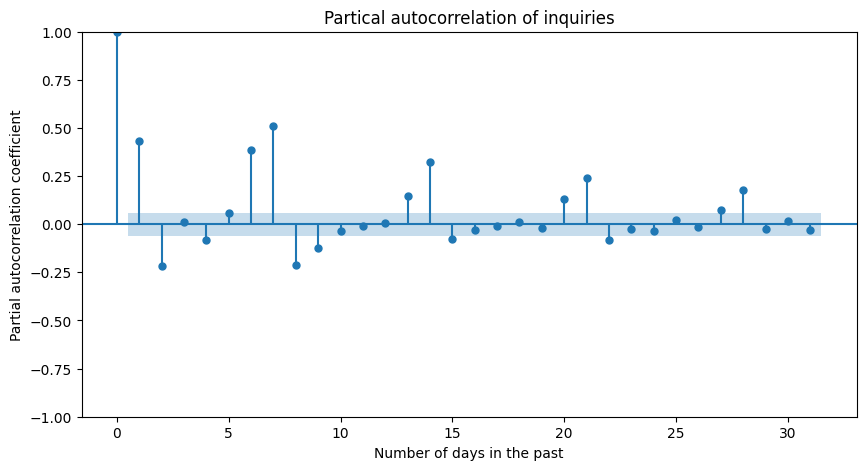

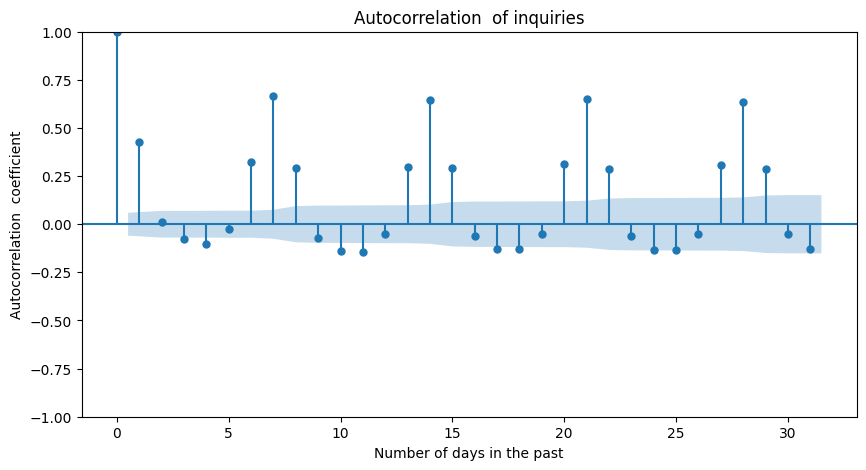

In [64]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plotting the partial autocorrelation for target
plot_pacf(daily_4_cluster_df['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_4_cluster_df['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [65]:
daily_4_cluster_df = get_features(daily_4_cluster_df,7)

### Modeling with Lazy Predict

In [66]:
final_4_df  = daily_4_cluster_df.drop(columns=['weekday', 'index']).fillna(0)
final_4_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Inq_mean_7'],
      dtype='object')

In [67]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_4_df['inquiries_per_day']
X = final_4_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:21<00:00,  1.91it/s]

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
GradientBoostingRegressor                    0.86       0.87    191.05   
RandomForestRegressor                        0.84       0.85    206.48   
BaggingRegressor                             0.82       0.84    213.43   
LGBMRegressor                                0.82       0.84    213.51   
HistGradientBoostingRegressor                0.82       0.83    214.17   
XGBRegressor                                 0.82       0.83    214.38   
KNeighborsRegressor                          0.82       0.83    215.64   
PoissonRegressor                             0.79       0.80    232.26   
LassoCV                                      0.78       0.79    241.72   
LarsCV                                       0.78       0.79    241.74   
LassoLarsCV                                  0.78       0.79    241.74   
LassoLarsIC                           

### RandomForestRegressor

In [68]:
# Load dataset into a pandas dataframe
df = final_4_df
# assigning X and y
y = final_4_df['inquiries_per_day']
X = final_4_df.drop(columns=['inquiries_per_day'])

# Split the dataset into training and test sets
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model on the training set using RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data, train_target)

# Make predictions on the test set
predictions = model.predict(test_data).astype(int)

# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse = mean_squared_error(test_target, predictions)

# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = predictions.var()
bias = mse - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Model: Random Forest Regressor
Variance: 277868.0074909519
Bias: -235277.96620654824


In [69]:
rmse = np.sqrt(mean_squared_error(test_target, predictions))
rmse

206.37354792803188

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [70]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_4_df['inquiries_per_day']
X = final_4_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1000}


Modeling with best parameters

In [71]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster4 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster4.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_4 = best_rfr_cluster4.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_4 = mean_absolute_error(y_train, train_pred_4)
train_rmse_4 = np.sqrt(mean_squared_error(y_train, train_pred_4))
print("Train MAE of Cluster #4: ", train_mae_4)
print('Train RMSE of Cluster #4:', train_rmse_4)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_4 = best_rfr_cluster4.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_4 = mean_absolute_error(y_test, test_pred_4)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_4 = mean_squared_error(y_test, test_pred_4)
test_rmse_4 = np.sqrt(mean_squared_error(y_test, test_pred_4))
print("Test MAE of Cluster #4: ", test_mae_4)
print('Test RMSE of Cluster #4:', test_rmse_4)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_4 = test_pred_4.var()
bias_4 = mse_4 - variance_4
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #4: {variance_4}')
print(f'Bias of Cluster #4: {bias_4}')

Train MAE of Cluster #4:  132.9045977011494
Train RMSE of Cluster #4: 233.88138019089934
Test MAE of Cluster #4:  186.10091743119267
Test RMSE of Cluster #4: 234.48006116207154
Model: Random Forest Regressor
Variance of Cluster #4: 221969.6624231967
Bias of Cluster #4: -166988.7633406279


Train MAE of Cluster #5:  205.11904761904762
Train RMSE of Cluster #5: 305.066875785128
Test MAE of Cluster #5:  283.8170731707317
Test RMSE of Cluster #5: 368.21515780725866
Model: Random Forest Regressor
Variance of Cluster #5: 155689.43080755504
Bias of Cluster #5: -20107.02836853065

Model: Random Forest Regressor
Variance: 375182.21355143504
Bias: -140199.54230831578

Data is not overfitting, but the low bias by default hyperparameters of RFRegressor is increased after hyperparameter tuning 

In [72]:
train_rf_4 = pd.DataFrame()
train_rf_4['actual_data'] = y_train
train_rf_4['predictions'] = train_pred_4
test_rf_4 = pd.DataFrame()
test_rf_4['actual_data'] = y_test
test_rf_4['predictions'] = test_pred_4
train_rf_4['residuals'] = train_rf_4['actual_data'] - train_rf_4['predictions']
test_rf_4['residuals'] = test_rf_4['actual_data'] - test_rf_4['predictions']

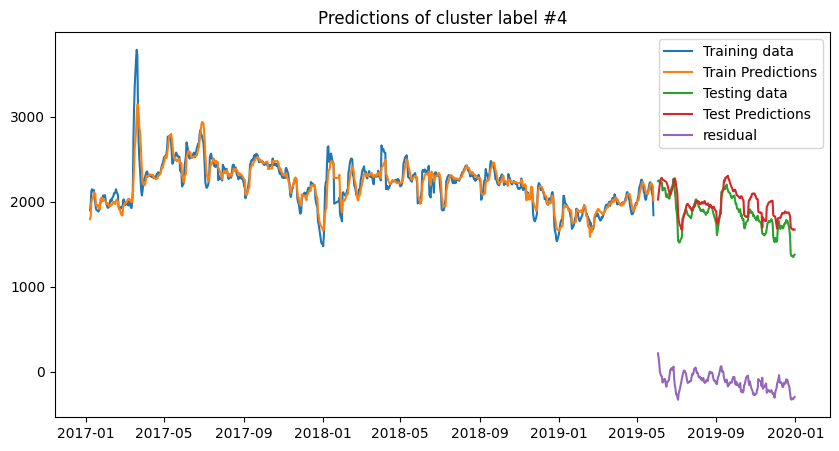

In [73]:
plt.title('Predictions of cluster label #4')
plt.plot(train_rf_4[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_4[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_4[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_4['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [74]:
new_plot=train_rf_4[train_rf_4.index.year == 2019]

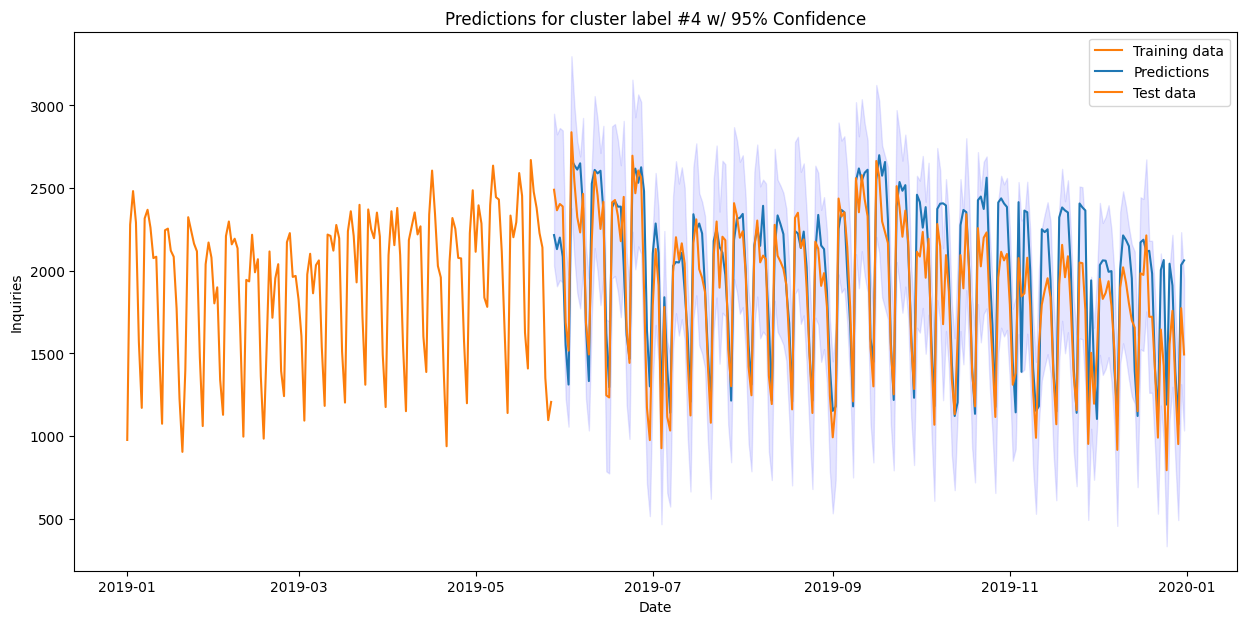

In [75]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_4['residuals'] ]) / len(test_rf_4['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_4.index, test_rf_4['predictions'], label='Predictions')
ax.plot(test_rf_4.index, test_rf_4['actual_data'], label='Test data')
ax.fill_between(test_rf_4.index, (test_rf_4['actual_data']-band_size), (test_rf_4['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #4 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

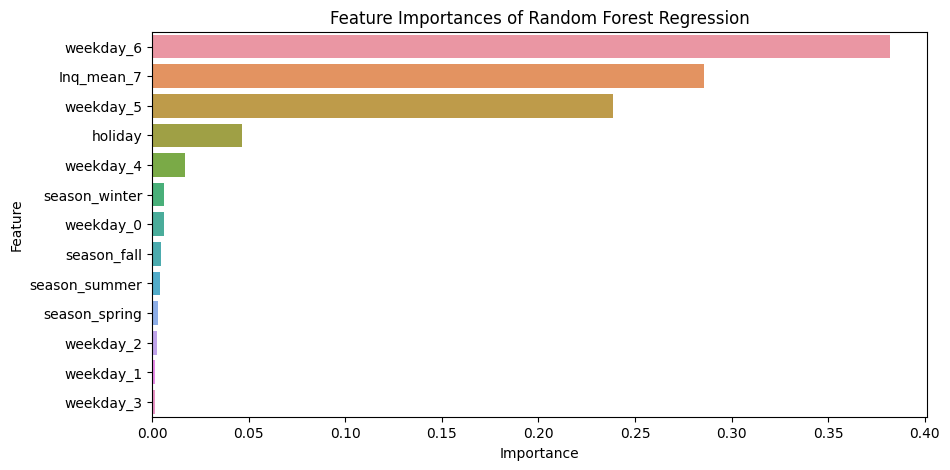

In [76]:
# Access the feature importances
importances = best_rfr_cluster4.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [77]:
test_rf_4

,actual_data,predictions,residuals
date,,,
2019-05-28,2490,2216,274
2019-05-29,2366,2131,235
2019-05-30,2404,2201,203
2019-05-31,2389,2085,304
2019-06-01,1688,1552,136
...,...,...,...
2019-12-27,1758,1911,-153
2019-12-28,1313,1391,-78
2019-12-29,952,1071,-119


In [78]:
train_rf_4

,actual_data,predictions,residuals
date,,,
2017-01-01,959,1072,-113
2017-01-02,1123,1194,-71
2017-01-03,2330,2220,110
2017-01-04,2444,2230,214
2017-01-05,2338,2213,125
...,...,...,...
2019-05-23,2228,2505,-277
2019-05-24,2141,2260,-119
2019-05-25,1352,1553,-201


# 4th Top cluster --> cluster_label = 11

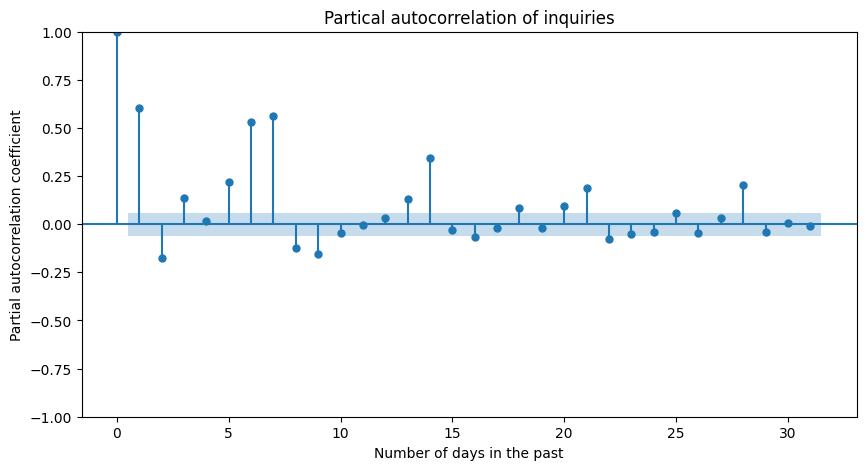

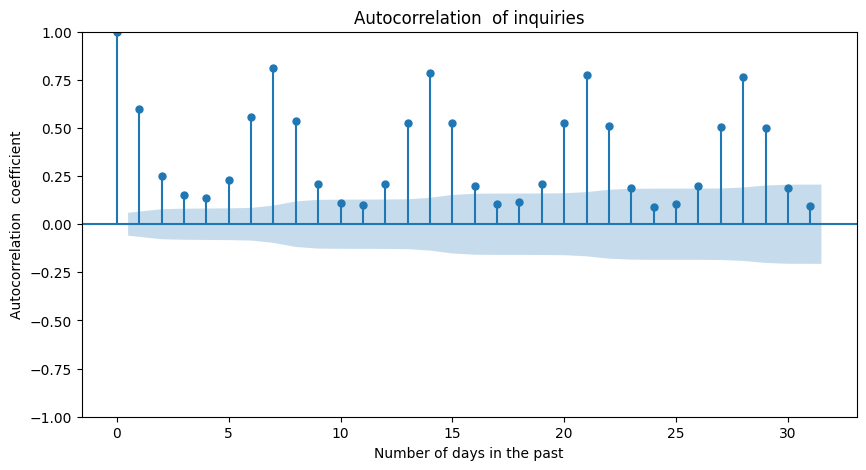

In [79]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plotting the partial autocorrelation for target
plot_pacf(daily_11_cluster_df['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_11_cluster_df['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [80]:
daily_11_cluster_df = get_features(daily_11_cluster_df,7)

### Modeling with Lazy Predict

In [81]:
final_11_df  = daily_11_cluster_df.drop(columns=['weekday', 'index']).fillna(0)
final_11_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Inq_mean_7'],
      dtype='object')

In [82]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_11_df['inquiries_per_day']
X = final_11_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:20<00:00,  2.01it/s]

                               Adjusted R-Squared  R-Squared     RMSE  \
Model                                                                   
GradientBoostingRegressor                    0.89       0.90   143.43   
RandomForestRegressor                        0.89       0.90   144.86   
XGBRegressor                                 0.88       0.89   152.17   
BaggingRegressor                             0.88       0.88   155.21   
ExtraTreesRegressor                          0.86       0.87   164.62   
HistGradientBoostingRegressor                0.85       0.86   169.87   
LGBMRegressor                                0.85       0.86   171.71   
ExtraTreeRegressor                           0.82       0.83   187.26   
DecisionTreeRegressor                        0.81       0.82   194.29   
KNeighborsRegressor                          0.81       0.82   194.70   
PoissonRegressor                             0.79       0.80   201.38   
RidgeCV                                      0.73  

### RandomForestRegressor

In [83]:
# Load dataset into a pandas dataframe
df = final_11_df
# assigning X and y
y = final_11_df['inquiries_per_day']
X = final_11_df.drop(columns=['inquiries_per_day'])

# Split the dataset into training and test sets
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model on the training set using RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data, train_target)

# Make predictions on the test set
predictions = model.predict(test_data).astype(int)

# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse = mean_squared_error(test_target, predictions)

# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = predictions.var()
bias = mse - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Model: Random Forest Regressor
Variance: 187923.1369623769
Bias: -166956.83421008333


In [84]:
rmse = np.sqrt(mean_squared_error(test_target, predictions))
rmse

144.79745423277848

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [85]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_11_df['inquiries_per_day']
X = final_11_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100}


Modeling with best parameters

In [86]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster11 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster11.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_11 = best_rfr_cluster4.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_11 = mean_absolute_error(y_train, train_pred_11)
train_rmse_11 = np.sqrt(mean_squared_error(y_train, train_pred_11))
print("Train MAE of Cluster #11: ", train_mae_11)
print('Train RMSE of Cluster #11:', train_rmse_11)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_11 = best_rfr_cluster11.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_11 = mean_absolute_error(y_test, test_pred_11)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_11 = mean_squared_error(y_test, test_pred_11)
test_rmse_11 = np.sqrt(mean_squared_error(y_test, test_pred_11))
print("Test MAE of Cluster #11: ", test_mae_11)
print('Test RMSE of Cluster #11:', test_rmse_11)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_11 = test_pred_11.var()
bias_11 = mse_11 - variance_11
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #11: {variance_11}')
print(f'Bias of Cluster #11: {bias_11}')

Train MAE of Cluster #11:  269.7988505747126
Train RMSE of Cluster #11: 357.5360169944783
Test MAE of Cluster #11:  143.3440366972477
Test RMSE of Cluster #11: 174.2222165337847
Model: Random Forest Regressor
Variance of Cluster #11: 47899.04974328761
Bias of Cluster #11: -17545.66900934265


Data is not overfitting, but the low bias by default hyperparameters of RFRegressor is increased after hyperparameter tuning 

In [87]:
train_rf_11 = pd.DataFrame()
train_rf_11['actual_data'] = y_train
train_rf_11['predictions'] = train_pred_11
test_rf_11 = pd.DataFrame()
test_rf_11['actual_data'] = y_test
test_rf_11['predictions'] = test_pred_11
train_rf_11['residuals'] = train_rf_11['actual_data'] - train_rf_11['predictions']
test_rf_11['residuals'] = test_rf_11['actual_data'] - test_rf_11['predictions']

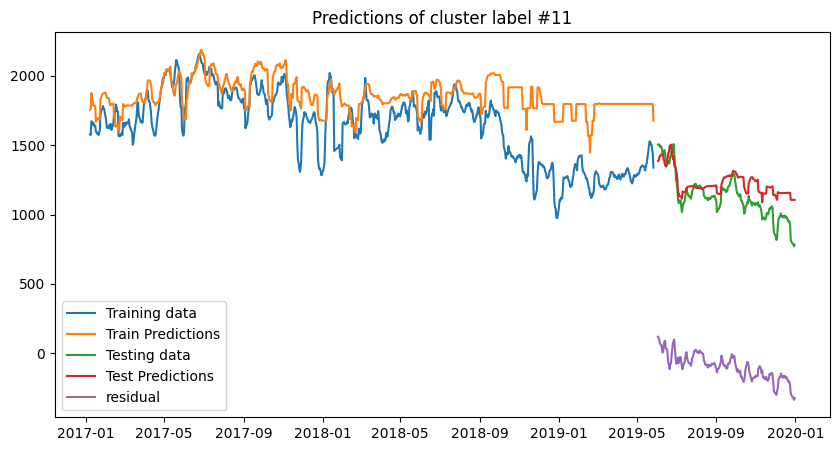

In [88]:
plt.title('Predictions of cluster label #11')
plt.plot(train_rf_11[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_11[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_11[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_11['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [89]:
new_plot=train_rf_11[train_rf_11.index.year == 2019]

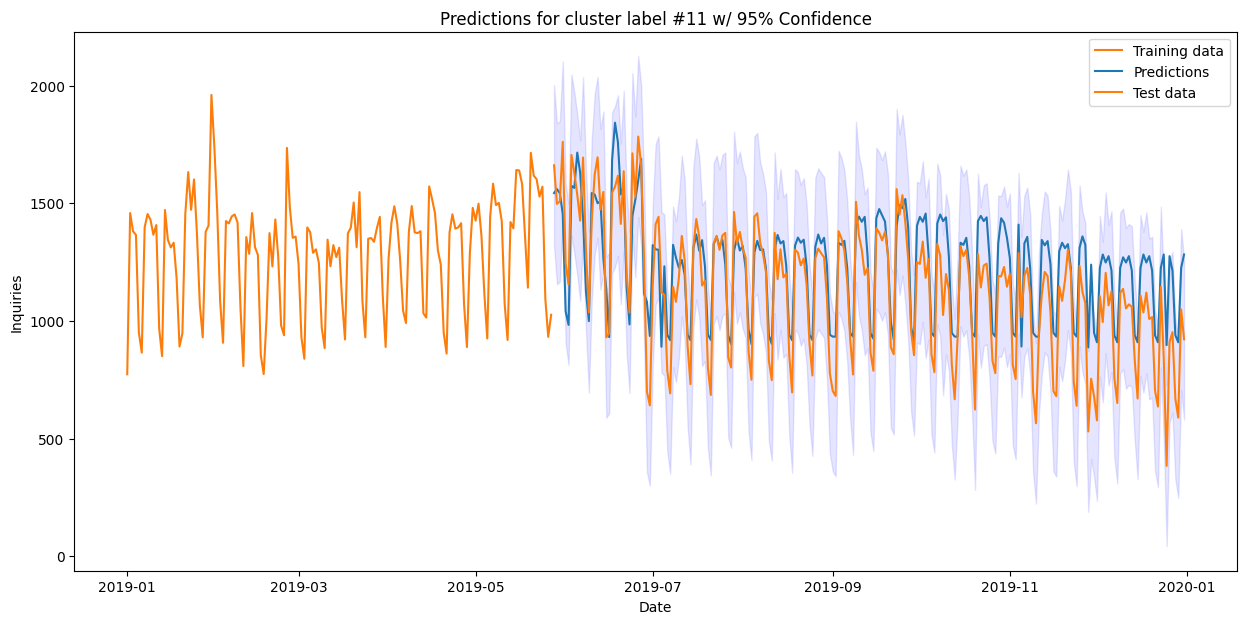

In [90]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_11['residuals'] ]) / len(test_rf_11['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_11.index, test_rf_11['predictions'], label='Predictions')
ax.plot(test_rf_11.index, test_rf_11['actual_data'], label='Test data')
ax.fill_between(test_rf_11.index, (test_rf_11['actual_data']-band_size), (test_rf_11['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #11 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

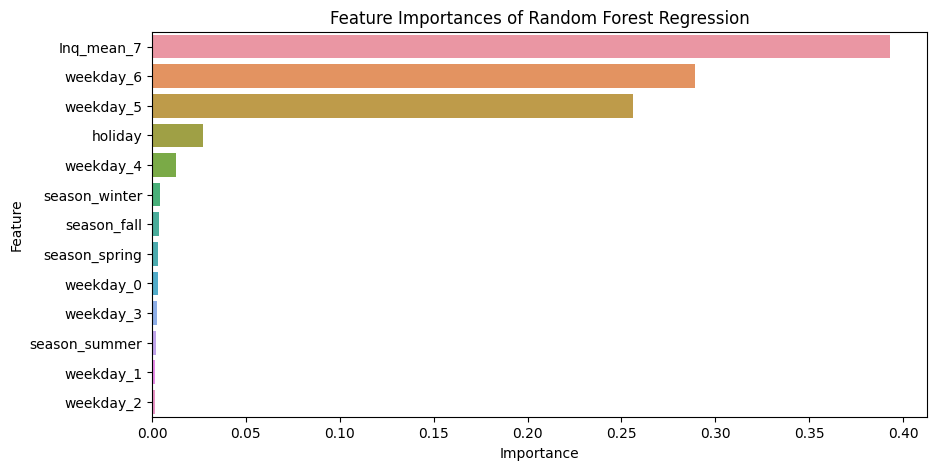

In [91]:
# Access the feature importances
importances = best_rfr_cluster11.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [92]:
test_rf_11

,actual_data,predictions,residuals
date,,,
2019-05-28,1661,1543,118
2019-05-29,1497,1560,-63
2019-05-30,1508,1542,-34
2019-05-31,1761,1455,306
2019-06-01,1244,1040,204
...,...,...,...
2019-12-27,952,1214,-262
2019-12-28,669,939,-270
2019-12-29,589,909,-320


In [93]:
train_rf_11

,actual_data,predictions,residuals
date,,,
2017-01-01,980,1072,-92
2017-01-02,1008,1194,-186
2017-01-03,1992,2220,-228
2017-01-04,2159,2230,-71
2017-01-05,1906,2213,-307
...,...,...,...
2019-05-23,1528,2038,-510
2019-05-24,1570,1914,-344
2019-05-25,1094,1397,-303


# 5th Top cluster --> cluster_label = 3

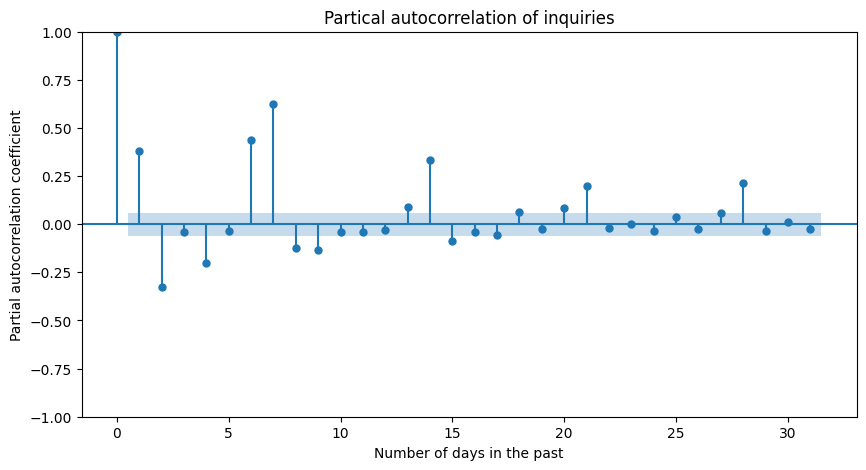

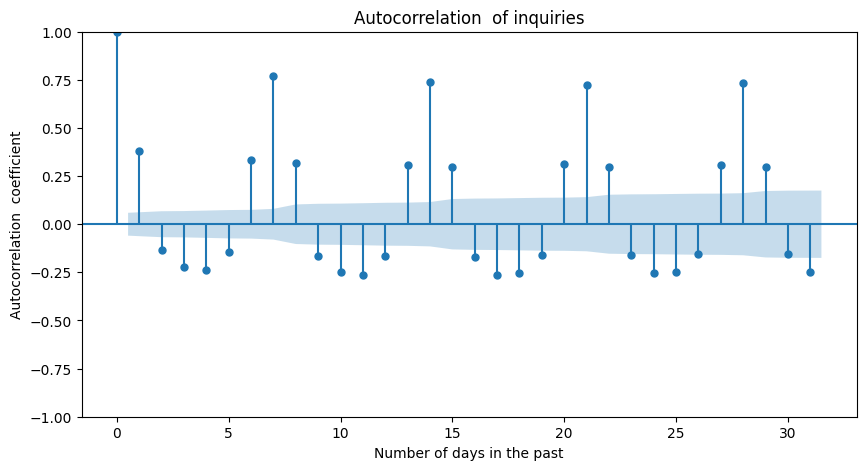

In [94]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plotting the partial autocorrelation for target
plot_pacf(daily_3_cluster_df['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_3_cluster_df['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [95]:
daily_3_cluster_df = get_features(daily_3_cluster_df,7)

### Modeling with Lazy Predict

In [96]:
final_3_df  = daily_3_cluster_df.drop(columns=['weekday', 'index']).fillna(0)
final_3_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Inq_mean_7'],
      dtype='object')

In [97]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_3_df['inquiries_per_day']
X = final_3_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:22<00:00,  1.88it/s]

                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
GradientBoostingRegressor                    0.78       0.79    256.19   
RandomForestRegressor                        0.75       0.77    269.93   
LGBMRegressor                                0.75       0.77    272.14   
HistGradientBoostingRegressor                0.75       0.76    272.50   
BaggingRegressor                             0.75       0.76    272.89   
RidgeCV                                      0.74       0.76    276.26   
BayesianRidge                                0.74       0.76    276.33   
Ridge                                        0.74       0.76    276.35   
Lars                                         0.74       0.76    276.37   
LassoCV                                      0.74       0.76    276.43   
LarsCV                                       0.74       0.76    276.43   
LassoLarsCV                           

### RandomForestRegressor

In [98]:
# Load dataset into a pandas dataframe
df = final_3_df
# assigning X and y
y = final_3_df['inquiries_per_day']
X = final_3_df.drop(columns=['inquiries_per_day'])

# Split the dataset into training and test sets
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model on the training set using RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data, train_target)

# Make predictions on the test set
predictions = model.predict(test_data).astype(int)

# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse = mean_squared_error(test_target, predictions)

# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = predictions.var()
bias = mse - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Model: Random Forest Regressor
Variance: 280801.83309485734
Bias: -207939.43401228852


In [99]:
rmse = np.sqrt(mean_squared_error(test_target, predictions))
rmse

269.9303596903631

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [100]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_3_df['inquiries_per_day']
X = final_3_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


Modeling with best parameters

In [101]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster3 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster3.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_3 = best_rfr_cluster3.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_3 = mean_absolute_error(y_train, train_pred_3)
train_rmse_3 = np.sqrt(mean_squared_error(y_train, train_pred_3))
print("Train MAE of Cluster #3: ", train_mae_3)
print('Train RMSE of Cluster #3:', train_rmse_3)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_3 = best_rfr_cluster3.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_3 = mean_absolute_error(y_test, test_pred_3)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_3 = mean_squared_error(y_test, test_pred_3)
test_rmse_3 = np.sqrt(mean_squared_error(y_test, test_pred_3))
print("Test MAE of Cluster #3: ", test_mae_3)
print('Test RMSE of Cluster #3:', test_rmse_3)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_3 = test_pred_3.var()
bias_3 = mse_3 - variance_3
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #3: {variance_3}')
print(f'Bias of Cluster #3: {bias_3}')

Train MAE of Cluster #3:  86.06666666666666
Train RMSE of Cluster #3: 126.17570307304419
Test MAE of Cluster #3:  344.91284403669727
Test RMSE of Cluster #3: 446.11627336132693
Model: Random Forest Regressor
Variance of Cluster #3: 305054.1337429509
Bias of Cluster #3: -106034.40438515274


Data is not overfitting, but the low bias by default hyperparameters of RFRegressor is increased after hyperparameter tuning 

In [102]:
train_rf_3 = pd.DataFrame()
train_rf_3['actual_data'] = y_train
train_rf_3['predictions'] = train_pred_3
test_rf_3 = pd.DataFrame()
test_rf_3['actual_data'] = y_test
test_rf_3['predictions'] = test_pred_3
train_rf_3['residuals'] = train_rf_3['actual_data'] - train_rf_3['predictions']
test_rf_3['residuals'] = test_rf_3['actual_data'] - test_rf_3['predictions']

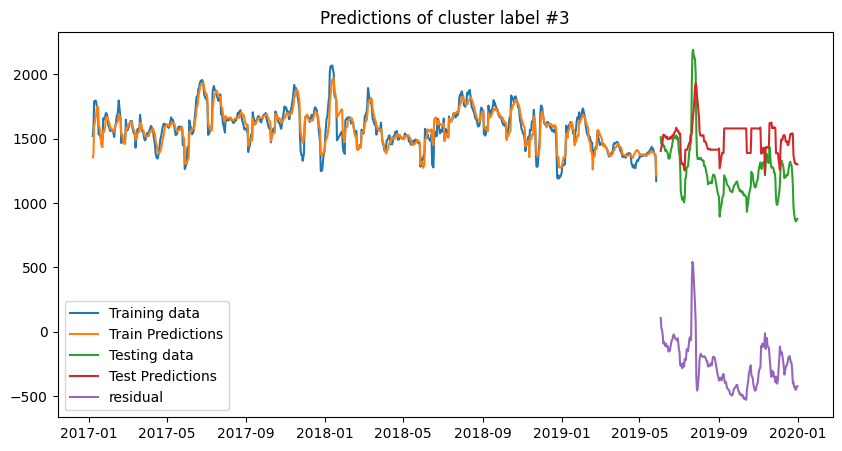

In [103]:
plt.title('Predictions of cluster label #3')
plt.plot(train_rf_3[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_3[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_3[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_3['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [104]:
new_plot=train_rf_3[train_rf_3.index.year == 2019]

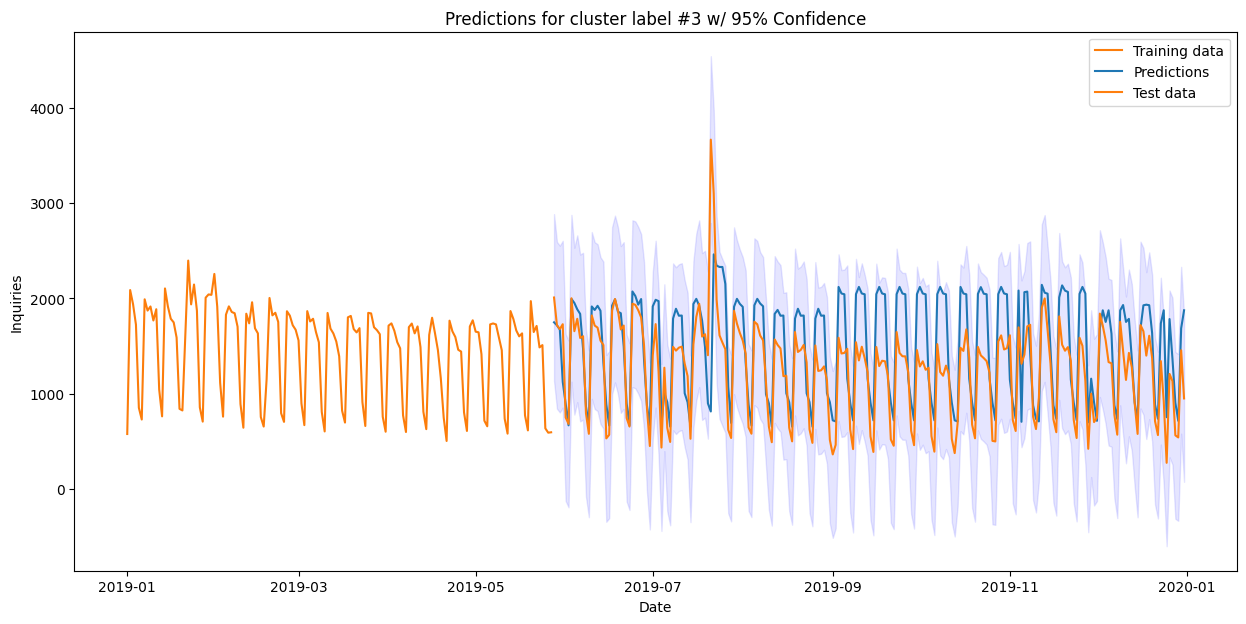

In [105]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_3['residuals'] ]) / len(test_rf_3['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_3.index, test_rf_3['predictions'], label='Predictions')
ax.plot(test_rf_3.index, test_rf_3['actual_data'], label='Test data')
ax.fill_between(test_rf_3.index, (test_rf_3['actual_data']-band_size), (test_rf_3['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #3 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

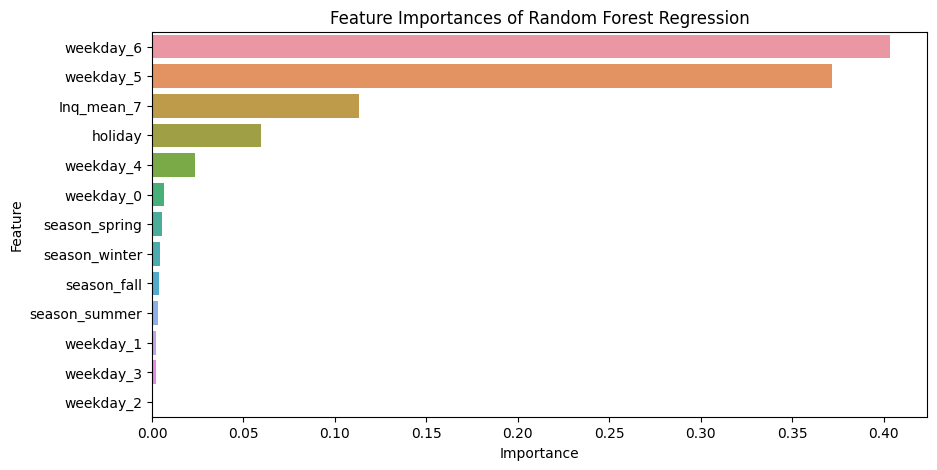

In [106]:
# Access the feature importances
importances = best_rfr_cluster3.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [107]:
test_rf_3

,actual_data,predictions,residuals
date,,,
2019-05-28,2010,1750,260
2019-05-29,1719,1719,0
2019-05-30,1679,1673,6
2019-05-31,1730,1125,605
2019-06-01,752,896,-144
...,...,...,...
2019-12-27,1134,1369,-235
2019-12-28,565,907,-342
2019-12-29,543,717,-174


In [108]:
train_rf_3

,actual_data,predictions,residuals
date,,,
2017-01-01,486,620,-134
2017-01-02,970,763,207
2017-01-03,2261,1988,273
2017-01-04,1914,1872,42
2017-01-05,2023,1890,133
...,...,...,...
2019-05-23,1487,1606,-119
2019-05-24,1511,1424,87
2019-05-25,638,761,-123


# 6th Top cluster --> cluster_label = 12

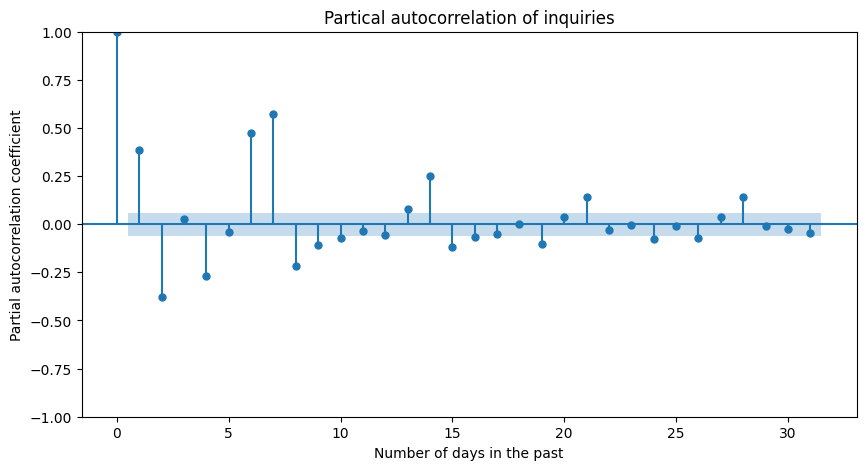

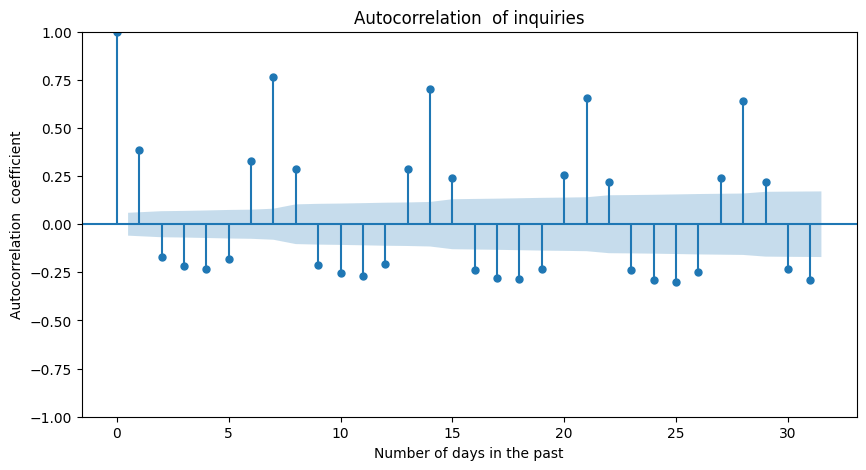

In [109]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# plotting the partial autocorrelation for target
plot_pacf(daily_12_cluster_df['inquiries_per_day'], title='Partical autocorrelation of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show()

plot_acf(daily_12_cluster_df['inquiries_per_day'], title='Autocorrelation  of inquiries',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation  coefficient')
plt.show()

In [110]:
daily_12_cluster_df = get_features(daily_12_cluster_df,7)

### Modeling with Lazy Predict

In [111]:
final_12_df  = daily_12_cluster_df.drop(columns=['weekday', 'index']).fillna(0)
final_12_df.columns

Index(['inquiries_per_day', 'season_spring', 'season_summer', 'season_fall',
       'season_winter', 'holiday', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'Inq_mean_7'],
      dtype='object')

In [112]:
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

# assigning X and y
y = final_12_df['inquiries_per_day']
X = final_12_df.drop(columns=['inquiries_per_day'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the LazyRegressor object and fit the data
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Print the results DataFrame
print(models)

100%|██████████| 42/42 [00:19<00:00,  2.17it/s]

                               Adjusted R-Squared   R-Squared      RMSE  \
Model                                                                     
PoissonRegressor                             0.86        0.87    292.93   
GradientBoostingRegressor                    0.86        0.86    299.68   
KNeighborsRegressor                          0.85        0.86    308.81   
HistGradientBoostingRegressor                0.84        0.85    311.63   
LGBMRegressor                                0.84        0.85    316.81   
BaggingRegressor                             0.84        0.85    317.08   
RandomForestRegressor                        0.84        0.85    317.20   
ExtraTreesRegressor                          0.83        0.84    328.94   
XGBRegressor                                 0.82        0.83    334.28   
TransformedTargetRegressor                   0.82        0.83    335.84   
LinearRegression                             0.82        0.83    335.84   
BayesianRidge            

### RandomForestRegressor

In [113]:
# Load dataset into a pandas dataframe
df = final_12_df
# assigning X and y
y = final_12_df['inquiries_per_day']
X = final_12_df.drop(columns=['inquiries_per_day'])

# Split the dataset into training and test sets
train_data, test_data, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model on the training set using RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data, train_target)

# Make predictions on the test set
predictions = model.predict(test_data).astype(int)

# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse = mean_squared_error(test_target, predictions)

# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance = predictions.var()
bias = mse - variance
print('Model: Random Forest Regressor')
print(f'Variance: {variance}')
print(f'Bias: {bias}')

Model: Random Forest Regressor
Variance: 615789.5491330696
Bias: -515216.50326150993


In [114]:
rmse = np.sqrt(mean_squared_error(test_target, predictions))
rmse

317.1325367595694

### Hyperparameter Tuning with cross validation

Grid search on combined dataset

In [115]:
from sklearn.model_selection import TimeSeriesSplit

# Set up the cross validation folds
tscv = TimeSeriesSplit(n_splits=5)
# Initialize models
grid_search_model = RandomForestRegressor(random_state=0)

# Set up the grid to pick hyperparameters from:
param_grid = {"n_estimators": [100, 500, 1000],
              "max_depth": [None],
              "min_samples_split": [2,3,5,7,8,10],
              "min_samples_leaf": [1,2,3],
              "bootstrap": [True]}

# Create the randomized search object
grid_search = GridSearchCV(grid_search_model, param_grid=param_grid , cv=tscv, 
                                   scoring="neg_mean_squared_error")

# Fit the model to the data
y = final_12_df['inquiries_per_day']
X = final_12_df.drop(columns=['inquiries_per_day'])

# set aside 30% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, shuffle = False, random_state = 0)


# Fit the randomized search on the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params_grid = grid_search.best_params_
print(best_params_grid)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


Modeling with best parameters

In [116]:
# use the best hyperparameters to create the final Random Forest Regressor model
best_rfr_cluster12 = RandomForestRegressor(n_estimators=best_params_grid['n_estimators'],
                                  max_depth=best_params_grid['max_depth'],
                                  min_samples_split=best_params_grid['min_samples_split'],
                                  min_samples_leaf=best_params_grid['min_samples_leaf'],
                                  bootstrap=True,
                                  random_state=0)

# fit the final Random Forest Regressor model to the full data
best_rfr_cluster12.fit(X_train, y_train)

# use the final Random Forest Regressor model to make predictions on the train set
train_pred_12 = best_rfr_cluster12.predict(X_train).astype(int)

# calculate the mean squared error of the predictions
train_mae_12 = mean_absolute_error(y_train, train_pred_12)
train_rmse_12 = np.sqrt(mean_squared_error(y_train, train_pred_12))
print("Train MAE of Cluster #12: ", train_mae_12)
print('Train RMSE of Cluster #12:', train_rmse_12)

# use the final Random Forest Regressor model to make predictions on the test set
test_pred_12 = best_rfr_cluster12.predict(X_test).astype(int)

# calculate the mean squared error of the predictions
test_mae_12 = mean_absolute_error(y_test, test_pred_12)
# Calculate the mean squared error (MSE) between the predicted values and the actual values in the test set
mse_12 = mean_squared_error(y_test, test_pred_12)
test_rmse_12 = np.sqrt(mean_squared_error(y_test, test_pred_12))
print("Test MAE of Cluster #12: ", test_mae_12)
print('Test RMSE of Cluster #12:', test_rmse_12)


# Calculate the variance and bias of the model based on the MSE and the actual values in the test set
variance_12 = test_pred_12.var()
bias_12 = mse_12 - variance_12
print('Model: Random Forest Regressor')
print(f'Variance of Cluster #12: {variance_12}')
print(f'Bias of Cluster #12: {bias_12}')

Train MAE of Cluster #12:  125.01724137931035
Train RMSE of Cluster #12: 218.73676774428753
Test MAE of Cluster #12:  182.4954128440367
Test RMSE of Cluster #12: 283.73881580835973
Model: Random Forest Regressor
Variance of Cluster #12: 584222.257406784
Bias of Cluster #12: -503714.5418104537


Data is not overfitting, but the low bias by default hyperparameters of RFRegressor is increased after hyperparameter tuning 

In [117]:
train_rf_12 = pd.DataFrame()
train_rf_12['actual_data'] = y_train
train_rf_12['predictions'] = train_pred_12
test_rf_12 = pd.DataFrame()
test_rf_12['actual_data'] = y_test
test_rf_12['predictions'] = test_pred_12
train_rf_12['residuals'] = train_rf_12['actual_data'] - train_rf_12['predictions']
test_rf_12['residuals'] = test_rf_12['actual_data'] - test_rf_12['predictions']

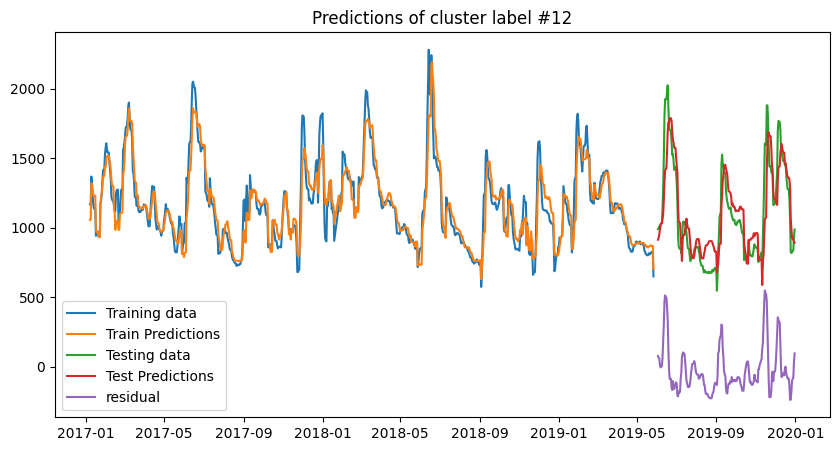

In [118]:
plt.title('Predictions of cluster label #12')
plt.plot(train_rf_12[['actual_data']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf_12[['predictions']].sort_index().rolling(7).mean(), label='Train Predictions')
plt.plot(test_rf_12[['actual_data','predictions']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_rf_12['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

In [119]:
new_plot=train_rf_12[train_rf_12.index.year == 2019]

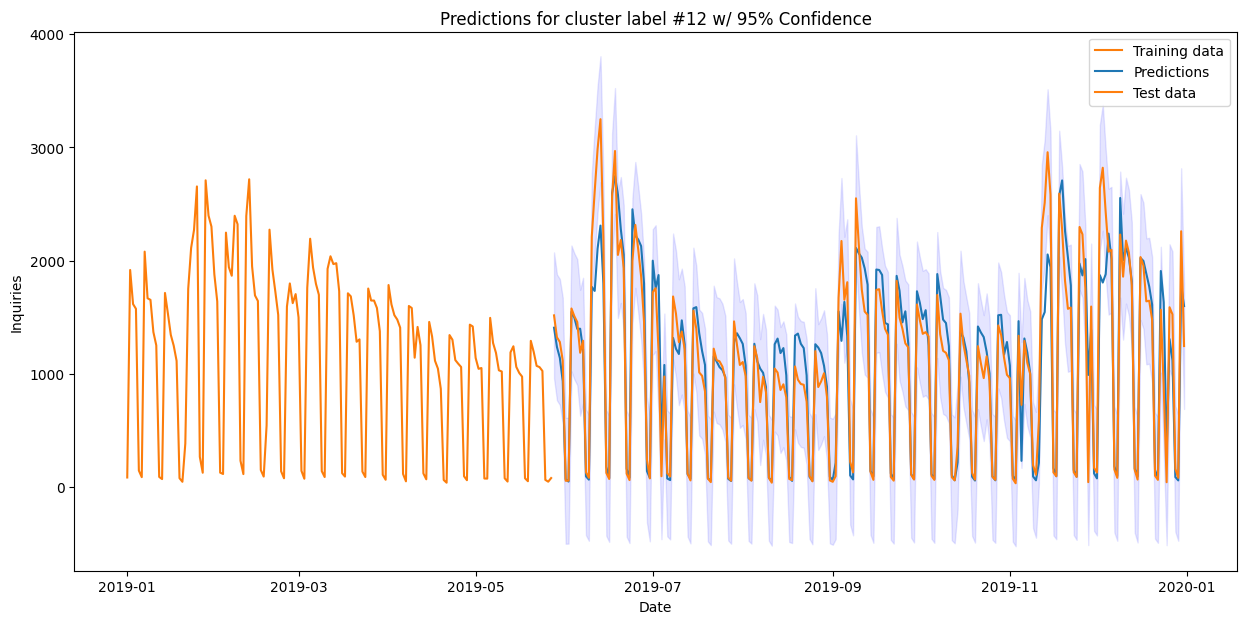

In [120]:
RMSFE = np.sqrt(sum([x**2 for x in test_rf_12['residuals'] ]) / len(test_rf_12['residuals'] ))
band_size = 1.96*RMSFE

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(new_plot.index, new_plot['actual_data'], color='#fc7d0b', label='Training data')
ax.plot(test_rf_12.index, test_rf_12['predictions'], label='Predictions')
ax.plot(test_rf_12.index, test_rf_12['actual_data'], label='Test data')
ax.fill_between(test_rf_12.index, (test_rf_12['actual_data']-band_size), (test_rf_12['actual_data']+band_size), color='b', alpha=.1)
ax.set_title("Predictions for cluster label #12 w/ 95% Confidence")
ax.set_xlabel('Date')
ax.set_ylabel('Inquiries')
plt.legend()
plt.show()

Feature Importance

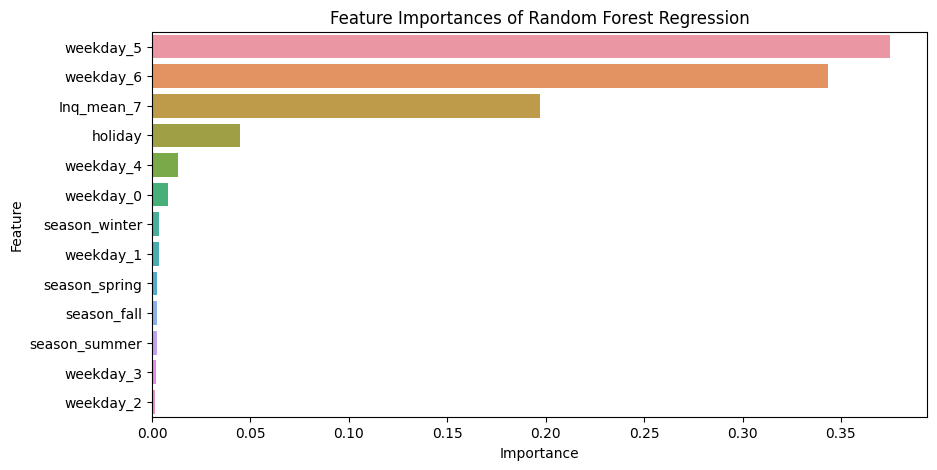

In [121]:
# Access the feature importances
importances = best_rfr_cluster12.feature_importances_

# Print the feature importances
#print("Feature importances:", importances)

# Create a dataframe with feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Sort the feature importances in descending order
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)

# Plot the feature importances using seaborn barplot
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of Random Forest Regression')
plt.show()


In [122]:
test_rf_12

,actual_data,predictions,residuals
date,,,
2019-05-28,1517,1408,109
2019-05-29,1323,1238,85
2019-05-30,1282,1142,140
2019-05-31,1118,936,182
2019-06-01,56,69,-13
...,...,...,...
2019-12-27,1526,1122,404
2019-12-28,162,89,73
2019-12-29,82,59,23


In [123]:
train_rf_12

,actual_data,predictions,residuals
date,,,
2017-01-01,54,59,-5
2017-01-02,374,200,174
2017-01-03,2299,1855,444
2017-01-04,1951,1846,105
2017-01-05,1807,1802,5
...,...,...,...
2019-05-23,1060,1127,-67
2019-05-24,1026,963,63
2019-05-25,64,74,-10


# Combining predictions

In [124]:
test_combined_clusters = pd.DataFrame()
test_combined_clusters['predictions'] = test_rf_5['predictions']+test_rf_7['predictions']+test_rf_4['predictions']+test_rf_11['predictions']+test_rf_3['predictions']+test_rf_12['predictions']

In [125]:
test_combined_clusters

,predictions
date,
2019-05-28,13057
2019-05-29,12583
2019-05-30,12533
2019-05-31,11181
2019-06-01,7664
...,...
2019-12-27,10054
2019-12-28,6687
2019-12-29,5706


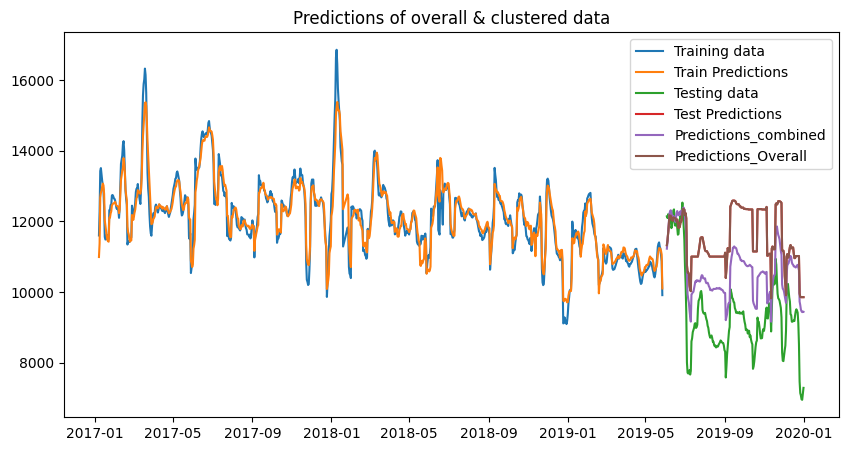

In [126]:
plt.title('Predictions of overall & clustered data')

plt.plot(train_rf[['train']].sort_index().rolling(7).mean(), label='Training data')
plt.plot(train_rf[['train_pred']].sort_index().rolling(7).mean(), label='Train Predictions')

plt.plot(predictions_rf[['test','test_pred']].sort_index().rolling(7).mean(), label=['Testing data','Test Predictions'])
plt.plot(test_combined_clusters['predictions'].fillna(0).sort_index().rolling(7).mean(),label='Predictions_combined')
plt.plot(predictions_rf['test_pred'].fillna(0).sort_index().rolling(7).mean(),label='Predictions_Overall')
#plt.plot(predictions_rf['residuals'].rolling(7).mean(), label = 'residual')
plt.legend();

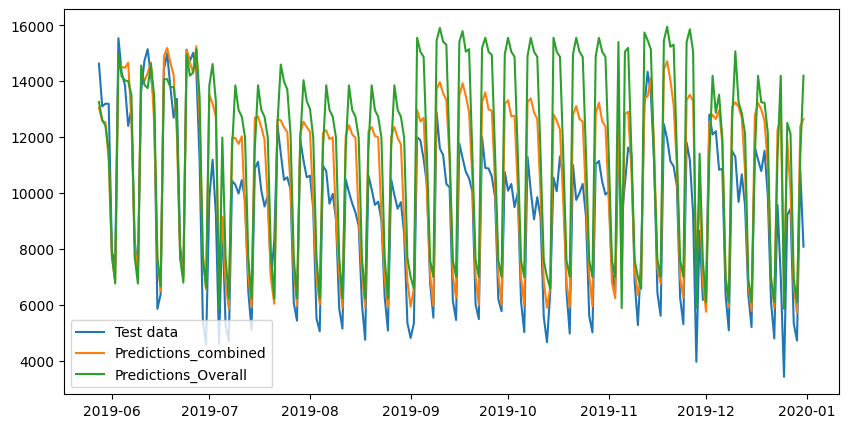

In [127]:
plt.plot(predictions_rf['test'].fillna(0),label='Test data')
plt.plot(test_combined_clusters['predictions'].fillna(0),label='Predictions_combined')
plt.plot(predictions_rf['test_pred'].fillna(0),label='Predictions_Overall')
plt.legend();